In [207]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable


# Do the dynamics of gradient descent in deep linear networks lead to a Fisher information about variables in the world prop. to the squared prior?

In [208]:
n_angles = 360

In [209]:
def simulate_data(mapping, prior, N=10000):
    """Each input example has an 'orientation'; it is some mapping of a circular variable binned into e.g. 
        n_angles degrees. 
        
       The orientations are sampled from the prior distribution.
       
       Inputs: mapping: a function that takes an array of orientations (1-hot vectors of size n_angles) 
                           and outputs corresponding examples
               prior: the prior distribution over orientations. shape (n_angles,)
               
       Outputs: examples: shape (N, output_dim)"""
    
    # make sure prior is normalized
    prior = prior / np.sum(prior)
    
    # get orientations
    orientations = np.random.choice(range(n_angles), size=N, p=prior)
    # make 1-hot
    orientations = np.eye(n_angles)[orientations]
    
    outputs = mapping(orientations)
    
    return outputs

Let's select a linear mapping from orientation to inputs. Since orientations are 1-hot we can treat them independently.

In [210]:
def get_orthogonal_matrix(size,gain=1):
    """Returns a random numpy matrix with orthogonal rows/columns."""
    mat = torch.zeros(*size)
    torch.nn.init.orthogonal_(mat,gain=gain)
    return mat.numpy()

In [211]:
OUTPUT_DIM = 100
lin_map = np.random.randn(n_angles,OUTPUT_DIM)
def linear_mapping(orientations_1hot, noise = 0):
    """Inputs: a matrix of shape (N,n_angles)
        Outputs: a matrix of shape (N, output_dim) representing the actual inputs
        noise"""
    
    outputs = np.dot(orientations_1hot, lin_map)
    return  outputs + noise*np.random.randn(*outputs.shape)

lin_map_ortho = get_orthogonal_matrix((n_angles,OUTPUT_DIM),gain=20)
def linear_mapping_ortho(orientations_1hot, noise = 0):
    """Inputs: a matrix of shape (N,n_angles)
        Outputs: a matrix of shape (N, output_dim) representing the actual inputs
        noise"""
    
    outputs = np.dot(orientations_1hot, lin_map_ortho)
    return  outputs + noise*np.random.randn(*outputs.shape)


Let's set the prior

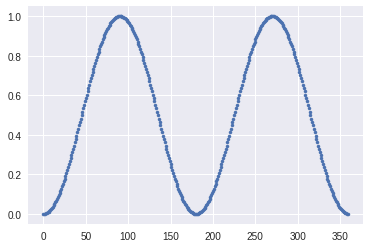

In [212]:
prior = np.sin(np.arange(n_angles)*np.pi/180)**2
plt.plot(prior,".")

In [213]:
data = simulate_data(linear_mapping, prior, N=100000)

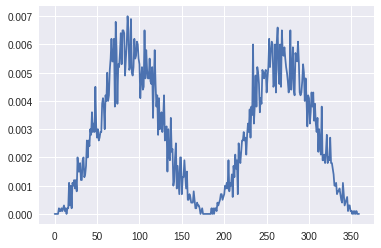

In [214]:
plt.plot(np.mean(simulate_data(lambda x:x, prior, N=10000),axis=0))

## Now let's set build a linear autoencoder (without tied weights)
This is like a 2-layer ANN, but here we're sure that 100% of the info in the inputs is necessary.

Srebro showed in 2017 that the path traced by gradient descent passes through the solutions to constrained-rank PCA.

In [215]:
def init_weights(m, gain = 1, method = 'orthogonal'):
    """initialize weight of Linear layer as constant_weight"""
    if method == 'orthogonal':
        if type(m) == torch.nn.Linear:
            torch.nn.init.orthogonal_(m.weight, gain=gain)
    elif method == 'xavier':
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, gain=gain)
    elif method == 'eye':
        if type(m) == torch.nn.Linear:
            torch.nn.init.eye_(m.weight)
            m.weight.data = m.weight.data.mul(gain)
            

In [216]:
class autoencoder(torch.nn.Module):
    def __init__(self, output_dim, inner_dim = 500, gain = .1, init_method = 'orthogonal'):
        """autoencoding with an expansion if inner_dim>100"""
        super(autoencoder, self).__init__()
        print(inner_dim, output_dim)
        self.l1 = torch.nn.Linear(output_dim, inner_dim )
        self.l2 = torch.nn.Linear(inner_dim, output_dim )
        
        init_weights(self.l1, gain = gain, method=init_method)
        init_weights(self.l2, gain = gain, method=init_method)

        
    def forward(self, x):
        return self.l2(self.l1(x))

#### train

### Now the Fisher

In [217]:
def get_orientation_fisher(network, linear_mapping):
    """Calculates the Fisher info of the hidden layer of the network as a function of orientation
    
    Gaussian noise assumption so just the square of the derivative.
    
    Which means just the weight matrix projected onto the mixing matrix in this noiseless case
    
    Note that eventually we can just do autograd back into the orientation if its built 
    """
    lin_map_torch = torch.from_numpy(linear_mapping).float().cuda()
    
    fish = torch.matmul(network.l1.weight, lin_map_torch.transpose(0,1))
    return torch.matmul(fish.transpose(0,1),fish)
    
    

In [218]:
!export CUDA_VISIBLE_DEVICES=0

In [219]:
def train_and_get_fishers(data, linear_mapping, init_gain = .01,lr = .1,
                              epochs = 5000, bs = 2056*32):
    """Trains via gradient descent
    
    Inputs:
            data: numpy array of (datapoints, n_features)
    
    Outputs:
            the trained model
            a vector of train loss
            the diagonal of the Fisher matrix at each epoch (shape epochs x output_dim)
            the weights after each epoch"""
    
    n_features = data.shape[1]

    ### define the network: pull from a conv2d layer of the pretrained vgg network and train on top of that
    auto_enc = autoencoder(n_features, gain=init_gain,init_method='orthogonal').cuda()

    optimizer = torch.optim.SGD(auto_enc.parameters(), lr)

    criterion = torch.nn.MSELoss()

    # Now loop through the data and train
    train_accuracy = []
    auto_enc.train()

    # go to cuda
    data_torch = Variable(torch.from_numpy(data).float())


    n_batches = data.shape[0]//bs
    train_loss = []
    fishers = np.zeros((epochs,n_angles))
    weights=[]
    for epoch in range(epochs):
        for batch in range(n_batches):
            data_cuda = data_torch[batch*bs:(batch+1)*bs].cuda()

            optimizer.zero_grad()
            output = auto_enc(data_cuda)

            loss = criterion(output, data_cuda)
            loss.backward()
            optimizer.step()
            del data_cuda

        train_loss.append(loss.data)

        print('Epoch: {} Train Loss: {:.6f} '.format(
            epoch + 1,
            loss.data))

        fish = torch.diag(get_orientation_fisher(auto_enc, linear_mapping)).detach().cpu().numpy()
        fishers[epoch] = fish
        weights.append(auto_enc.l1.weight.cpu().detach().numpy())
        
    return auto_enc, train_loss, fishers, weights


500 100
Epoch: 1 Train Loss: 0.995528 
Epoch: 2 Train Loss: 0.995453 
Epoch: 3 Train Loss: 0.995379 
Epoch: 4 Train Loss: 0.995306 
Epoch: 5 Train Loss: 0.995233 
Epoch: 6 Train Loss: 0.995160 
Epoch: 7 Train Loss: 0.995088 
Epoch: 8 Train Loss: 0.995017 
Epoch: 9 Train Loss: 0.994946 
Epoch: 10 Train Loss: 0.994875 
Epoch: 11 Train Loss: 0.994805 
Epoch: 12 Train Loss: 0.994735 
Epoch: 13 Train Loss: 0.994666 
Epoch: 14 Train Loss: 0.994597 
Epoch: 15 Train Loss: 0.994529 
Epoch: 16 Train Loss: 0.994460 
Epoch: 17 Train Loss: 0.994393 
Epoch: 18 Train Loss: 0.994325 
Epoch: 19 Train Loss: 0.994259 
Epoch: 20 Train Loss: 0.994192 
Epoch: 21 Train Loss: 0.994126 
Epoch: 22 Train Loss: 0.994060 
Epoch: 23 Train Loss: 0.993995 
Epoch: 24 Train Loss: 0.993930 
Epoch: 25 Train Loss: 0.993865 
Epoch: 26 Train Loss: 0.993800 
Epoch: 27 Train Loss: 0.993736 
Epoch: 28 Train Loss: 0.993673 
Epoch: 29 Train Loss: 0.993609 
Epoch: 30 Train Loss: 0.993546 
Epoch: 31 Train Loss: 0.993483 
Epoch: 32

Epoch: 263 Train Loss: 0.977669 
Epoch: 264 Train Loss: 0.977558 
Epoch: 265 Train Loss: 0.977446 
Epoch: 266 Train Loss: 0.977334 
Epoch: 267 Train Loss: 0.977220 
Epoch: 268 Train Loss: 0.977106 
Epoch: 269 Train Loss: 0.976991 
Epoch: 270 Train Loss: 0.976876 
Epoch: 271 Train Loss: 0.976759 
Epoch: 272 Train Loss: 0.976642 
Epoch: 273 Train Loss: 0.976524 
Epoch: 274 Train Loss: 0.976406 
Epoch: 275 Train Loss: 0.976286 
Epoch: 276 Train Loss: 0.976166 
Epoch: 277 Train Loss: 0.976044 
Epoch: 278 Train Loss: 0.975922 
Epoch: 279 Train Loss: 0.975799 
Epoch: 280 Train Loss: 0.975676 
Epoch: 281 Train Loss: 0.975551 
Epoch: 282 Train Loss: 0.975426 
Epoch: 283 Train Loss: 0.975299 
Epoch: 284 Train Loss: 0.975172 
Epoch: 285 Train Loss: 0.975044 
Epoch: 286 Train Loss: 0.974915 
Epoch: 287 Train Loss: 0.974786 
Epoch: 288 Train Loss: 0.974655 
Epoch: 289 Train Loss: 0.974523 
Epoch: 290 Train Loss: 0.974391 
Epoch: 291 Train Loss: 0.974257 
Epoch: 292 Train Loss: 0.974123 
Epoch: 293

Epoch: 514 Train Loss: 0.904118 
Epoch: 515 Train Loss: 0.903538 
Epoch: 516 Train Loss: 0.902955 
Epoch: 517 Train Loss: 0.902369 
Epoch: 518 Train Loss: 0.901780 
Epoch: 519 Train Loss: 0.901188 
Epoch: 520 Train Loss: 0.900593 
Epoch: 521 Train Loss: 0.899995 
Epoch: 522 Train Loss: 0.899394 
Epoch: 523 Train Loss: 0.898790 
Epoch: 524 Train Loss: 0.898184 
Epoch: 525 Train Loss: 0.897574 
Epoch: 526 Train Loss: 0.896961 
Epoch: 527 Train Loss: 0.896345 
Epoch: 528 Train Loss: 0.895727 
Epoch: 529 Train Loss: 0.895105 
Epoch: 530 Train Loss: 0.894480 
Epoch: 531 Train Loss: 0.893853 
Epoch: 532 Train Loss: 0.893222 
Epoch: 533 Train Loss: 0.892589 
Epoch: 534 Train Loss: 0.891952 
Epoch: 535 Train Loss: 0.891313 
Epoch: 536 Train Loss: 0.890670 
Epoch: 537 Train Loss: 0.890025 
Epoch: 538 Train Loss: 0.889377 
Epoch: 539 Train Loss: 0.888726 
Epoch: 540 Train Loss: 0.888071 
Epoch: 541 Train Loss: 0.887414 
Epoch: 542 Train Loss: 0.886754 
Epoch: 543 Train Loss: 0.886091 
Epoch: 544

Epoch: 772 Train Loss: 0.687436 
Epoch: 773 Train Loss: 0.686530 
Epoch: 774 Train Loss: 0.685625 
Epoch: 775 Train Loss: 0.684721 
Epoch: 776 Train Loss: 0.683818 
Epoch: 777 Train Loss: 0.682915 
Epoch: 778 Train Loss: 0.682014 
Epoch: 779 Train Loss: 0.681114 
Epoch: 780 Train Loss: 0.680214 
Epoch: 781 Train Loss: 0.679315 
Epoch: 782 Train Loss: 0.678418 
Epoch: 783 Train Loss: 0.677521 
Epoch: 784 Train Loss: 0.676625 
Epoch: 785 Train Loss: 0.675731 
Epoch: 786 Train Loss: 0.674837 
Epoch: 787 Train Loss: 0.673944 
Epoch: 788 Train Loss: 0.673052 
Epoch: 789 Train Loss: 0.672161 
Epoch: 790 Train Loss: 0.671272 
Epoch: 791 Train Loss: 0.670383 
Epoch: 792 Train Loss: 0.669495 
Epoch: 793 Train Loss: 0.668608 
Epoch: 794 Train Loss: 0.667722 
Epoch: 795 Train Loss: 0.666838 
Epoch: 796 Train Loss: 0.665954 
Epoch: 797 Train Loss: 0.665071 
Epoch: 798 Train Loss: 0.664190 
Epoch: 799 Train Loss: 0.663310 
Epoch: 800 Train Loss: 0.662430 
Epoch: 801 Train Loss: 0.661552 
Epoch: 802

Epoch: 1025 Train Loss: 0.495891 
Epoch: 1026 Train Loss: 0.495286 
Epoch: 1027 Train Loss: 0.494683 
Epoch: 1028 Train Loss: 0.494080 
Epoch: 1029 Train Loss: 0.493479 
Epoch: 1030 Train Loss: 0.492879 
Epoch: 1031 Train Loss: 0.492280 
Epoch: 1032 Train Loss: 0.491682 
Epoch: 1033 Train Loss: 0.491084 
Epoch: 1034 Train Loss: 0.490488 
Epoch: 1035 Train Loss: 0.489893 
Epoch: 1036 Train Loss: 0.489299 
Epoch: 1037 Train Loss: 0.488706 
Epoch: 1038 Train Loss: 0.488114 
Epoch: 1039 Train Loss: 0.487523 
Epoch: 1040 Train Loss: 0.486933 
Epoch: 1041 Train Loss: 0.486344 
Epoch: 1042 Train Loss: 0.485757 
Epoch: 1043 Train Loss: 0.485170 
Epoch: 1044 Train Loss: 0.484584 
Epoch: 1045 Train Loss: 0.483999 
Epoch: 1046 Train Loss: 0.483415 
Epoch: 1047 Train Loss: 0.482832 
Epoch: 1048 Train Loss: 0.482250 
Epoch: 1049 Train Loss: 0.481669 
Epoch: 1050 Train Loss: 0.481090 
Epoch: 1051 Train Loss: 0.480511 
Epoch: 1052 Train Loss: 0.479933 
Epoch: 1053 Train Loss: 0.479356 
Epoch: 1054 Tr

Epoch: 1267 Train Loss: 0.375162 
Epoch: 1268 Train Loss: 0.374753 
Epoch: 1269 Train Loss: 0.374344 
Epoch: 1270 Train Loss: 0.373936 
Epoch: 1271 Train Loss: 0.373529 
Epoch: 1272 Train Loss: 0.373122 
Epoch: 1273 Train Loss: 0.372716 
Epoch: 1274 Train Loss: 0.372311 
Epoch: 1275 Train Loss: 0.371906 
Epoch: 1276 Train Loss: 0.371501 
Epoch: 1277 Train Loss: 0.371098 
Epoch: 1278 Train Loss: 0.370695 
Epoch: 1279 Train Loss: 0.370292 
Epoch: 1280 Train Loss: 0.369890 
Epoch: 1281 Train Loss: 0.369489 
Epoch: 1282 Train Loss: 0.369089 
Epoch: 1283 Train Loss: 0.368689 
Epoch: 1284 Train Loss: 0.368289 
Epoch: 1285 Train Loss: 0.367891 
Epoch: 1286 Train Loss: 0.367493 
Epoch: 1287 Train Loss: 0.367095 
Epoch: 1288 Train Loss: 0.366698 
Epoch: 1289 Train Loss: 0.366302 
Epoch: 1290 Train Loss: 0.365906 
Epoch: 1291 Train Loss: 0.365511 
Epoch: 1292 Train Loss: 0.365117 
Epoch: 1293 Train Loss: 0.364723 
Epoch: 1294 Train Loss: 0.364329 
Epoch: 1295 Train Loss: 0.363937 
Epoch: 1296 Tr

Epoch: 1514 Train Loss: 0.290468 
Epoch: 1515 Train Loss: 0.290182 
Epoch: 1516 Train Loss: 0.289896 
Epoch: 1517 Train Loss: 0.289610 
Epoch: 1518 Train Loss: 0.289325 
Epoch: 1519 Train Loss: 0.289040 
Epoch: 1520 Train Loss: 0.288756 
Epoch: 1521 Train Loss: 0.288472 
Epoch: 1522 Train Loss: 0.288188 
Epoch: 1523 Train Loss: 0.287905 
Epoch: 1524 Train Loss: 0.287622 
Epoch: 1525 Train Loss: 0.287339 
Epoch: 1526 Train Loss: 0.287057 
Epoch: 1527 Train Loss: 0.286775 
Epoch: 1528 Train Loss: 0.286494 
Epoch: 1529 Train Loss: 0.286213 
Epoch: 1530 Train Loss: 0.285932 
Epoch: 1531 Train Loss: 0.285652 
Epoch: 1532 Train Loss: 0.285372 
Epoch: 1533 Train Loss: 0.285092 
Epoch: 1534 Train Loss: 0.284813 
Epoch: 1535 Train Loss: 0.284534 
Epoch: 1536 Train Loss: 0.284256 
Epoch: 1537 Train Loss: 0.283977 
Epoch: 1538 Train Loss: 0.283700 
Epoch: 1539 Train Loss: 0.283422 
Epoch: 1540 Train Loss: 0.283145 
Epoch: 1541 Train Loss: 0.282869 
Epoch: 1542 Train Loss: 0.282592 
Epoch: 1543 Tr

Epoch: 1756 Train Loss: 0.230940 
Epoch: 1757 Train Loss: 0.230731 
Epoch: 1758 Train Loss: 0.230521 
Epoch: 1759 Train Loss: 0.230312 
Epoch: 1760 Train Loss: 0.230103 
Epoch: 1761 Train Loss: 0.229894 
Epoch: 1762 Train Loss: 0.229686 
Epoch: 1763 Train Loss: 0.229477 
Epoch: 1764 Train Loss: 0.229269 
Epoch: 1765 Train Loss: 0.229062 
Epoch: 1766 Train Loss: 0.228854 
Epoch: 1767 Train Loss: 0.228647 
Epoch: 1768 Train Loss: 0.228440 
Epoch: 1769 Train Loss: 0.228234 
Epoch: 1770 Train Loss: 0.228027 
Epoch: 1771 Train Loss: 0.227821 
Epoch: 1772 Train Loss: 0.227615 
Epoch: 1773 Train Loss: 0.227410 
Epoch: 1774 Train Loss: 0.227205 
Epoch: 1775 Train Loss: 0.227000 
Epoch: 1776 Train Loss: 0.226795 
Epoch: 1777 Train Loss: 0.226590 
Epoch: 1778 Train Loss: 0.226386 
Epoch: 1779 Train Loss: 0.226182 
Epoch: 1780 Train Loss: 0.225978 
Epoch: 1781 Train Loss: 0.225775 
Epoch: 1782 Train Loss: 0.225571 
Epoch: 1783 Train Loss: 0.225369 
Epoch: 1784 Train Loss: 0.225166 
Epoch: 1785 Tr

Epoch: 2005 Train Loss: 0.186113 
Epoch: 2006 Train Loss: 0.185960 
Epoch: 2007 Train Loss: 0.185807 
Epoch: 2008 Train Loss: 0.185654 
Epoch: 2009 Train Loss: 0.185501 
Epoch: 2010 Train Loss: 0.185348 
Epoch: 2011 Train Loss: 0.185196 
Epoch: 2012 Train Loss: 0.185043 
Epoch: 2013 Train Loss: 0.184891 
Epoch: 2014 Train Loss: 0.184739 
Epoch: 2015 Train Loss: 0.184588 
Epoch: 2016 Train Loss: 0.184436 
Epoch: 2017 Train Loss: 0.184285 
Epoch: 2018 Train Loss: 0.184133 
Epoch: 2019 Train Loss: 0.183982 
Epoch: 2020 Train Loss: 0.183831 
Epoch: 2021 Train Loss: 0.183681 
Epoch: 2022 Train Loss: 0.183530 
Epoch: 2023 Train Loss: 0.183380 
Epoch: 2024 Train Loss: 0.183230 
Epoch: 2025 Train Loss: 0.183080 
Epoch: 2026 Train Loss: 0.182930 
Epoch: 2027 Train Loss: 0.182781 
Epoch: 2028 Train Loss: 0.182631 
Epoch: 2029 Train Loss: 0.182482 
Epoch: 2030 Train Loss: 0.182333 
Epoch: 2031 Train Loss: 0.182184 
Epoch: 2032 Train Loss: 0.182036 
Epoch: 2033 Train Loss: 0.181887 
Epoch: 2034 Tr

Epoch: 2249 Train Loss: 0.153487 
Epoch: 2250 Train Loss: 0.153371 
Epoch: 2251 Train Loss: 0.153254 
Epoch: 2252 Train Loss: 0.153138 
Epoch: 2253 Train Loss: 0.153022 
Epoch: 2254 Train Loss: 0.152906 
Epoch: 2255 Train Loss: 0.152790 
Epoch: 2256 Train Loss: 0.152674 
Epoch: 2257 Train Loss: 0.152558 
Epoch: 2258 Train Loss: 0.152443 
Epoch: 2259 Train Loss: 0.152327 
Epoch: 2260 Train Loss: 0.152212 
Epoch: 2261 Train Loss: 0.152097 
Epoch: 2262 Train Loss: 0.151982 
Epoch: 2263 Train Loss: 0.151867 
Epoch: 2264 Train Loss: 0.151752 
Epoch: 2265 Train Loss: 0.151637 
Epoch: 2266 Train Loss: 0.151523 
Epoch: 2267 Train Loss: 0.151408 
Epoch: 2268 Train Loss: 0.151294 
Epoch: 2269 Train Loss: 0.151180 
Epoch: 2270 Train Loss: 0.151066 
Epoch: 2271 Train Loss: 0.150952 
Epoch: 2272 Train Loss: 0.150838 
Epoch: 2273 Train Loss: 0.150724 
Epoch: 2274 Train Loss: 0.150610 
Epoch: 2275 Train Loss: 0.150497 
Epoch: 2276 Train Loss: 0.150383 
Epoch: 2277 Train Loss: 0.150270 
Epoch: 2278 Tr

Epoch: 2495 Train Loss: 0.128052 
Epoch: 2496 Train Loss: 0.127961 
Epoch: 2497 Train Loss: 0.127869 
Epoch: 2498 Train Loss: 0.127778 
Epoch: 2499 Train Loss: 0.127686 
Epoch: 2500 Train Loss: 0.127595 
Epoch: 2501 Train Loss: 0.127504 
Epoch: 2502 Train Loss: 0.127412 
Epoch: 2503 Train Loss: 0.127321 
Epoch: 2504 Train Loss: 0.127230 
Epoch: 2505 Train Loss: 0.127139 
Epoch: 2506 Train Loss: 0.127049 
Epoch: 2507 Train Loss: 0.126958 
Epoch: 2508 Train Loss: 0.126867 
Epoch: 2509 Train Loss: 0.126777 
Epoch: 2510 Train Loss: 0.126686 
Epoch: 2511 Train Loss: 0.126596 
Epoch: 2512 Train Loss: 0.126505 
Epoch: 2513 Train Loss: 0.126415 
Epoch: 2514 Train Loss: 0.126325 
Epoch: 2515 Train Loss: 0.126235 
Epoch: 2516 Train Loss: 0.126145 
Epoch: 2517 Train Loss: 0.126055 
Epoch: 2518 Train Loss: 0.125965 
Epoch: 2519 Train Loss: 0.125876 
Epoch: 2520 Train Loss: 0.125786 
Epoch: 2521 Train Loss: 0.125696 
Epoch: 2522 Train Loss: 0.125607 
Epoch: 2523 Train Loss: 0.125517 
Epoch: 2524 Tr

Epoch: 2746 Train Loss: 0.107460 
Epoch: 2747 Train Loss: 0.107387 
Epoch: 2748 Train Loss: 0.107314 
Epoch: 2749 Train Loss: 0.107240 
Epoch: 2750 Train Loss: 0.107167 
Epoch: 2751 Train Loss: 0.107094 
Epoch: 2752 Train Loss: 0.107022 
Epoch: 2753 Train Loss: 0.106949 
Epoch: 2754 Train Loss: 0.106876 
Epoch: 2755 Train Loss: 0.106803 
Epoch: 2756 Train Loss: 0.106731 
Epoch: 2757 Train Loss: 0.106658 
Epoch: 2758 Train Loss: 0.106585 
Epoch: 2759 Train Loss: 0.106513 
Epoch: 2760 Train Loss: 0.106440 
Epoch: 2761 Train Loss: 0.106368 
Epoch: 2762 Train Loss: 0.106296 
Epoch: 2763 Train Loss: 0.106224 
Epoch: 2764 Train Loss: 0.106151 
Epoch: 2765 Train Loss: 0.106079 
Epoch: 2766 Train Loss: 0.106007 
Epoch: 2767 Train Loss: 0.105935 
Epoch: 2768 Train Loss: 0.105863 
Epoch: 2769 Train Loss: 0.105792 
Epoch: 2770 Train Loss: 0.105720 
Epoch: 2771 Train Loss: 0.105648 
Epoch: 2772 Train Loss: 0.105576 
Epoch: 2773 Train Loss: 0.105505 
Epoch: 2774 Train Loss: 0.105433 
Epoch: 2775 Tr

Epoch: 2992 Train Loss: 0.091188 
Epoch: 2993 Train Loss: 0.091128 
Epoch: 2994 Train Loss: 0.091069 
Epoch: 2995 Train Loss: 0.091009 
Epoch: 2996 Train Loss: 0.090950 
Epoch: 2997 Train Loss: 0.090890 
Epoch: 2998 Train Loss: 0.090831 
Epoch: 2999 Train Loss: 0.090772 
Epoch: 3000 Train Loss: 0.090712 
Epoch: 3001 Train Loss: 0.090653 
Epoch: 3002 Train Loss: 0.090594 
Epoch: 3003 Train Loss: 0.090535 
Epoch: 3004 Train Loss: 0.090475 
Epoch: 3005 Train Loss: 0.090416 
Epoch: 3006 Train Loss: 0.090357 
Epoch: 3007 Train Loss: 0.090298 
Epoch: 3008 Train Loss: 0.090239 
Epoch: 3009 Train Loss: 0.090180 
Epoch: 3010 Train Loss: 0.090122 
Epoch: 3011 Train Loss: 0.090063 
Epoch: 3012 Train Loss: 0.090004 
Epoch: 3013 Train Loss: 0.089945 
Epoch: 3014 Train Loss: 0.089887 
Epoch: 3015 Train Loss: 0.089828 
Epoch: 3016 Train Loss: 0.089769 
Epoch: 3017 Train Loss: 0.089711 
Epoch: 3018 Train Loss: 0.089653 
Epoch: 3019 Train Loss: 0.089594 
Epoch: 3020 Train Loss: 0.089536 
Epoch: 3021 Tr

Epoch: 3240 Train Loss: 0.077727 
Epoch: 3241 Train Loss: 0.077678 
Epoch: 3242 Train Loss: 0.077629 
Epoch: 3243 Train Loss: 0.077580 
Epoch: 3244 Train Loss: 0.077530 
Epoch: 3245 Train Loss: 0.077481 
Epoch: 3246 Train Loss: 0.077432 
Epoch: 3247 Train Loss: 0.077383 
Epoch: 3248 Train Loss: 0.077334 
Epoch: 3249 Train Loss: 0.077285 
Epoch: 3250 Train Loss: 0.077236 
Epoch: 3251 Train Loss: 0.077187 
Epoch: 3252 Train Loss: 0.077138 
Epoch: 3253 Train Loss: 0.077089 
Epoch: 3254 Train Loss: 0.077040 
Epoch: 3255 Train Loss: 0.076991 
Epoch: 3256 Train Loss: 0.076942 
Epoch: 3257 Train Loss: 0.076894 
Epoch: 3258 Train Loss: 0.076845 
Epoch: 3259 Train Loss: 0.076796 
Epoch: 3260 Train Loss: 0.076748 
Epoch: 3261 Train Loss: 0.076699 
Epoch: 3262 Train Loss: 0.076650 
Epoch: 3263 Train Loss: 0.076602 
Epoch: 3264 Train Loss: 0.076553 
Epoch: 3265 Train Loss: 0.076505 
Epoch: 3266 Train Loss: 0.076456 
Epoch: 3267 Train Loss: 0.076408 
Epoch: 3268 Train Loss: 0.076360 
Epoch: 3269 Tr

Epoch: 3486 Train Loss: 0.066607 
Epoch: 3487 Train Loss: 0.066565 
Epoch: 3488 Train Loss: 0.066524 
Epoch: 3489 Train Loss: 0.066483 
Epoch: 3490 Train Loss: 0.066441 
Epoch: 3491 Train Loss: 0.066400 
Epoch: 3492 Train Loss: 0.066359 
Epoch: 3493 Train Loss: 0.066318 
Epoch: 3494 Train Loss: 0.066277 
Epoch: 3495 Train Loss: 0.066236 
Epoch: 3496 Train Loss: 0.066195 
Epoch: 3497 Train Loss: 0.066154 
Epoch: 3498 Train Loss: 0.066113 
Epoch: 3499 Train Loss: 0.066072 
Epoch: 3500 Train Loss: 0.066031 
Epoch: 3501 Train Loss: 0.065990 
Epoch: 3502 Train Loss: 0.065949 
Epoch: 3503 Train Loss: 0.065908 
Epoch: 3504 Train Loss: 0.065867 
Epoch: 3505 Train Loss: 0.065826 
Epoch: 3506 Train Loss: 0.065785 
Epoch: 3507 Train Loss: 0.065745 
Epoch: 3508 Train Loss: 0.065704 
Epoch: 3509 Train Loss: 0.065663 
Epoch: 3510 Train Loss: 0.065623 
Epoch: 3511 Train Loss: 0.065582 
Epoch: 3512 Train Loss: 0.065541 
Epoch: 3513 Train Loss: 0.065501 
Epoch: 3514 Train Loss: 0.065460 
Epoch: 3515 Tr

Epoch: 3741 Train Loss: 0.056956 
Epoch: 3742 Train Loss: 0.056922 
Epoch: 3743 Train Loss: 0.056887 
Epoch: 3744 Train Loss: 0.056853 
Epoch: 3745 Train Loss: 0.056818 
Epoch: 3746 Train Loss: 0.056784 
Epoch: 3747 Train Loss: 0.056750 
Epoch: 3748 Train Loss: 0.056715 
Epoch: 3749 Train Loss: 0.056681 
Epoch: 3750 Train Loss: 0.056647 
Epoch: 3751 Train Loss: 0.056612 
Epoch: 3752 Train Loss: 0.056578 
Epoch: 3753 Train Loss: 0.056544 
Epoch: 3754 Train Loss: 0.056509 
Epoch: 3755 Train Loss: 0.056475 
Epoch: 3756 Train Loss: 0.056441 
Epoch: 3757 Train Loss: 0.056407 
Epoch: 3758 Train Loss: 0.056373 
Epoch: 3759 Train Loss: 0.056339 
Epoch: 3760 Train Loss: 0.056305 
Epoch: 3761 Train Loss: 0.056270 
Epoch: 3762 Train Loss: 0.056236 
Epoch: 3763 Train Loss: 0.056202 
Epoch: 3764 Train Loss: 0.056168 
Epoch: 3765 Train Loss: 0.056134 
Epoch: 3766 Train Loss: 0.056100 
Epoch: 3767 Train Loss: 0.056067 
Epoch: 3768 Train Loss: 0.056033 
Epoch: 3769 Train Loss: 0.055999 
Epoch: 3770 Tr

Epoch: 3991 Train Loss: 0.049042 
Epoch: 3992 Train Loss: 0.049013 
Epoch: 3993 Train Loss: 0.048984 
Epoch: 3994 Train Loss: 0.048955 
Epoch: 3995 Train Loss: 0.048926 
Epoch: 3996 Train Loss: 0.048897 
Epoch: 3997 Train Loss: 0.048869 
Epoch: 3998 Train Loss: 0.048840 
Epoch: 3999 Train Loss: 0.048811 
Epoch: 4000 Train Loss: 0.048782 
Epoch: 4001 Train Loss: 0.048754 
Epoch: 4002 Train Loss: 0.048725 
Epoch: 4003 Train Loss: 0.048696 
Epoch: 4004 Train Loss: 0.048667 
Epoch: 4005 Train Loss: 0.048639 
Epoch: 4006 Train Loss: 0.048610 
Epoch: 4007 Train Loss: 0.048581 
Epoch: 4008 Train Loss: 0.048553 
Epoch: 4009 Train Loss: 0.048524 
Epoch: 4010 Train Loss: 0.048496 
Epoch: 4011 Train Loss: 0.048467 
Epoch: 4012 Train Loss: 0.048439 
Epoch: 4013 Train Loss: 0.048410 
Epoch: 4014 Train Loss: 0.048382 
Epoch: 4015 Train Loss: 0.048353 
Epoch: 4016 Train Loss: 0.048325 
Epoch: 4017 Train Loss: 0.048296 
Epoch: 4018 Train Loss: 0.048268 
Epoch: 4019 Train Loss: 0.048240 
Epoch: 4020 Tr

Epoch: 4238 Train Loss: 0.042479 
Epoch: 4239 Train Loss: 0.042455 
Epoch: 4240 Train Loss: 0.042431 
Epoch: 4241 Train Loss: 0.042406 
Epoch: 4242 Train Loss: 0.042382 
Epoch: 4243 Train Loss: 0.042358 
Epoch: 4244 Train Loss: 0.042334 
Epoch: 4245 Train Loss: 0.042309 
Epoch: 4246 Train Loss: 0.042285 
Epoch: 4247 Train Loss: 0.042261 
Epoch: 4248 Train Loss: 0.042237 
Epoch: 4249 Train Loss: 0.042213 
Epoch: 4250 Train Loss: 0.042188 
Epoch: 4251 Train Loss: 0.042164 
Epoch: 4252 Train Loss: 0.042140 
Epoch: 4253 Train Loss: 0.042116 
Epoch: 4254 Train Loss: 0.042092 
Epoch: 4255 Train Loss: 0.042068 
Epoch: 4256 Train Loss: 0.042044 
Epoch: 4257 Train Loss: 0.042020 
Epoch: 4258 Train Loss: 0.041996 
Epoch: 4259 Train Loss: 0.041972 
Epoch: 4260 Train Loss: 0.041948 
Epoch: 4261 Train Loss: 0.041924 
Epoch: 4262 Train Loss: 0.041900 
Epoch: 4263 Train Loss: 0.041876 
Epoch: 4264 Train Loss: 0.041852 
Epoch: 4265 Train Loss: 0.041828 
Epoch: 4266 Train Loss: 0.041804 
Epoch: 4267 Tr

Epoch: 4484 Train Loss: 0.036959 
Epoch: 4485 Train Loss: 0.036938 
Epoch: 4486 Train Loss: 0.036918 
Epoch: 4487 Train Loss: 0.036897 
Epoch: 4488 Train Loss: 0.036876 
Epoch: 4489 Train Loss: 0.036856 
Epoch: 4490 Train Loss: 0.036835 
Epoch: 4491 Train Loss: 0.036814 
Epoch: 4492 Train Loss: 0.036794 
Epoch: 4493 Train Loss: 0.036773 
Epoch: 4494 Train Loss: 0.036753 
Epoch: 4495 Train Loss: 0.036732 
Epoch: 4496 Train Loss: 0.036712 
Epoch: 4497 Train Loss: 0.036691 
Epoch: 4498 Train Loss: 0.036671 
Epoch: 4499 Train Loss: 0.036650 
Epoch: 4500 Train Loss: 0.036630 
Epoch: 4501 Train Loss: 0.036609 
Epoch: 4502 Train Loss: 0.036589 
Epoch: 4503 Train Loss: 0.036568 
Epoch: 4504 Train Loss: 0.036548 
Epoch: 4505 Train Loss: 0.036528 
Epoch: 4506 Train Loss: 0.036507 
Epoch: 4507 Train Loss: 0.036487 
Epoch: 4508 Train Loss: 0.036467 
Epoch: 4509 Train Loss: 0.036446 
Epoch: 4510 Train Loss: 0.036426 
Epoch: 4511 Train Loss: 0.036405 
Epoch: 4512 Train Loss: 0.036385 
Epoch: 4513 Tr

Epoch: 4725 Train Loss: 0.032333 
Epoch: 4726 Train Loss: 0.032315 
Epoch: 4727 Train Loss: 0.032298 
Epoch: 4728 Train Loss: 0.032280 
Epoch: 4729 Train Loss: 0.032262 
Epoch: 4730 Train Loss: 0.032244 
Epoch: 4731 Train Loss: 0.032227 
Epoch: 4732 Train Loss: 0.032209 
Epoch: 4733 Train Loss: 0.032191 
Epoch: 4734 Train Loss: 0.032173 
Epoch: 4735 Train Loss: 0.032156 
Epoch: 4736 Train Loss: 0.032138 
Epoch: 4737 Train Loss: 0.032120 
Epoch: 4738 Train Loss: 0.032102 
Epoch: 4739 Train Loss: 0.032085 
Epoch: 4740 Train Loss: 0.032067 
Epoch: 4741 Train Loss: 0.032049 
Epoch: 4742 Train Loss: 0.032032 
Epoch: 4743 Train Loss: 0.032014 
Epoch: 4744 Train Loss: 0.031996 
Epoch: 4745 Train Loss: 0.031979 
Epoch: 4746 Train Loss: 0.031961 
Epoch: 4747 Train Loss: 0.031944 
Epoch: 4748 Train Loss: 0.031926 
Epoch: 4749 Train Loss: 0.031908 
Epoch: 4750 Train Loss: 0.031891 
Epoch: 4751 Train Loss: 0.031873 
Epoch: 4752 Train Loss: 0.031856 
Epoch: 4753 Train Loss: 0.031838 
Epoch: 4754 Tr

Epoch: 4974 Train Loss: 0.028195 
Epoch: 4975 Train Loss: 0.028180 
Epoch: 4976 Train Loss: 0.028164 
Epoch: 4977 Train Loss: 0.028149 
Epoch: 4978 Train Loss: 0.028133 
Epoch: 4979 Train Loss: 0.028118 
Epoch: 4980 Train Loss: 0.028102 
Epoch: 4981 Train Loss: 0.028087 
Epoch: 4982 Train Loss: 0.028071 
Epoch: 4983 Train Loss: 0.028056 
Epoch: 4984 Train Loss: 0.028040 
Epoch: 4985 Train Loss: 0.028025 
Epoch: 4986 Train Loss: 0.028010 
Epoch: 4987 Train Loss: 0.027994 
Epoch: 4988 Train Loss: 0.027979 
Epoch: 4989 Train Loss: 0.027963 
Epoch: 4990 Train Loss: 0.027948 
Epoch: 4991 Train Loss: 0.027933 
Epoch: 4992 Train Loss: 0.027917 
Epoch: 4993 Train Loss: 0.027902 
Epoch: 4994 Train Loss: 0.027887 
Epoch: 4995 Train Loss: 0.027871 
Epoch: 4996 Train Loss: 0.027856 
Epoch: 4997 Train Loss: 0.027841 
Epoch: 4998 Train Loss: 0.027825 
Epoch: 4999 Train Loss: 0.027810 
Epoch: 5000 Train Loss: 0.027795 
Epoch: 5001 Train Loss: 0.027780 
Epoch: 5002 Train Loss: 0.027764 
Epoch: 5003 Tr

Epoch: 5215 Train Loss: 0.024687 
Epoch: 5216 Train Loss: 0.024673 
Epoch: 5217 Train Loss: 0.024660 
Epoch: 5218 Train Loss: 0.024646 
Epoch: 5219 Train Loss: 0.024632 
Epoch: 5220 Train Loss: 0.024619 
Epoch: 5221 Train Loss: 0.024605 
Epoch: 5222 Train Loss: 0.024591 
Epoch: 5223 Train Loss: 0.024578 
Epoch: 5224 Train Loss: 0.024564 
Epoch: 5225 Train Loss: 0.024551 
Epoch: 5226 Train Loss: 0.024537 
Epoch: 5227 Train Loss: 0.024523 
Epoch: 5228 Train Loss: 0.024510 
Epoch: 5229 Train Loss: 0.024496 
Epoch: 5230 Train Loss: 0.024483 
Epoch: 5231 Train Loss: 0.024469 
Epoch: 5232 Train Loss: 0.024456 
Epoch: 5233 Train Loss: 0.024442 
Epoch: 5234 Train Loss: 0.024429 
Epoch: 5235 Train Loss: 0.024415 
Epoch: 5236 Train Loss: 0.024401 
Epoch: 5237 Train Loss: 0.024388 
Epoch: 5238 Train Loss: 0.024374 
Epoch: 5239 Train Loss: 0.024361 
Epoch: 5240 Train Loss: 0.024347 
Epoch: 5241 Train Loss: 0.024334 
Epoch: 5242 Train Loss: 0.024320 
Epoch: 5243 Train Loss: 0.024307 
Epoch: 5244 Tr

Epoch: 5468 Train Loss: 0.021441 
Epoch: 5469 Train Loss: 0.021429 
Epoch: 5470 Train Loss: 0.021417 
Epoch: 5471 Train Loss: 0.021405 
Epoch: 5472 Train Loss: 0.021393 
Epoch: 5473 Train Loss: 0.021381 
Epoch: 5474 Train Loss: 0.021369 
Epoch: 5475 Train Loss: 0.021357 
Epoch: 5476 Train Loss: 0.021345 
Epoch: 5477 Train Loss: 0.021333 
Epoch: 5478 Train Loss: 0.021321 
Epoch: 5479 Train Loss: 0.021309 
Epoch: 5480 Train Loss: 0.021297 
Epoch: 5481 Train Loss: 0.021285 
Epoch: 5482 Train Loss: 0.021273 
Epoch: 5483 Train Loss: 0.021261 
Epoch: 5484 Train Loss: 0.021249 
Epoch: 5485 Train Loss: 0.021237 
Epoch: 5486 Train Loss: 0.021225 
Epoch: 5487 Train Loss: 0.021213 
Epoch: 5488 Train Loss: 0.021202 
Epoch: 5489 Train Loss: 0.021190 
Epoch: 5490 Train Loss: 0.021178 
Epoch: 5491 Train Loss: 0.021166 
Epoch: 5492 Train Loss: 0.021154 
Epoch: 5493 Train Loss: 0.021142 
Epoch: 5494 Train Loss: 0.021130 
Epoch: 5495 Train Loss: 0.021118 
Epoch: 5496 Train Loss: 0.021106 
Epoch: 5497 Tr

Epoch: 5723 Train Loss: 0.018560 
Epoch: 5724 Train Loss: 0.018550 
Epoch: 5725 Train Loss: 0.018539 
Epoch: 5726 Train Loss: 0.018528 
Epoch: 5727 Train Loss: 0.018518 
Epoch: 5728 Train Loss: 0.018507 
Epoch: 5729 Train Loss: 0.018497 
Epoch: 5730 Train Loss: 0.018486 
Epoch: 5731 Train Loss: 0.018476 
Epoch: 5732 Train Loss: 0.018465 
Epoch: 5733 Train Loss: 0.018454 
Epoch: 5734 Train Loss: 0.018444 
Epoch: 5735 Train Loss: 0.018433 
Epoch: 5736 Train Loss: 0.018423 
Epoch: 5737 Train Loss: 0.018412 
Epoch: 5738 Train Loss: 0.018402 
Epoch: 5739 Train Loss: 0.018391 
Epoch: 5740 Train Loss: 0.018381 
Epoch: 5741 Train Loss: 0.018370 
Epoch: 5742 Train Loss: 0.018360 
Epoch: 5743 Train Loss: 0.018349 
Epoch: 5744 Train Loss: 0.018339 
Epoch: 5745 Train Loss: 0.018328 
Epoch: 5746 Train Loss: 0.018318 
Epoch: 5747 Train Loss: 0.018307 
Epoch: 5748 Train Loss: 0.018297 
Epoch: 5749 Train Loss: 0.018287 
Epoch: 5750 Train Loss: 0.018276 
Epoch: 5751 Train Loss: 0.018266 
Epoch: 5752 Tr

Epoch: 5976 Train Loss: 0.016045 
Epoch: 5977 Train Loss: 0.016035 
Epoch: 5978 Train Loss: 0.016026 
Epoch: 5979 Train Loss: 0.016017 
Epoch: 5980 Train Loss: 0.016007 
Epoch: 5981 Train Loss: 0.015998 
Epoch: 5982 Train Loss: 0.015989 
Epoch: 5983 Train Loss: 0.015979 
Epoch: 5984 Train Loss: 0.015970 
Epoch: 5985 Train Loss: 0.015961 
Epoch: 5986 Train Loss: 0.015952 
Epoch: 5987 Train Loss: 0.015942 
Epoch: 5988 Train Loss: 0.015933 
Epoch: 5989 Train Loss: 0.015924 
Epoch: 5990 Train Loss: 0.015915 
Epoch: 5991 Train Loss: 0.015905 
Epoch: 5992 Train Loss: 0.015896 
Epoch: 5993 Train Loss: 0.015887 
Epoch: 5994 Train Loss: 0.015878 
Epoch: 5995 Train Loss: 0.015868 
Epoch: 5996 Train Loss: 0.015859 
Epoch: 5997 Train Loss: 0.015850 
Epoch: 5998 Train Loss: 0.015841 
Epoch: 5999 Train Loss: 0.015831 
Epoch: 6000 Train Loss: 0.015822 
Epoch: 6001 Train Loss: 0.015813 
Epoch: 6002 Train Loss: 0.015804 
Epoch: 6003 Train Loss: 0.015795 
Epoch: 6004 Train Loss: 0.015785 
Epoch: 6005 Tr

Epoch: 6230 Train Loss: 0.013825 
Epoch: 6231 Train Loss: 0.013817 
Epoch: 6232 Train Loss: 0.013809 
Epoch: 6233 Train Loss: 0.013801 
Epoch: 6234 Train Loss: 0.013792 
Epoch: 6235 Train Loss: 0.013784 
Epoch: 6236 Train Loss: 0.013776 
Epoch: 6237 Train Loss: 0.013768 
Epoch: 6238 Train Loss: 0.013760 
Epoch: 6239 Train Loss: 0.013752 
Epoch: 6240 Train Loss: 0.013744 
Epoch: 6241 Train Loss: 0.013735 
Epoch: 6242 Train Loss: 0.013727 
Epoch: 6243 Train Loss: 0.013719 
Epoch: 6244 Train Loss: 0.013711 
Epoch: 6245 Train Loss: 0.013703 
Epoch: 6246 Train Loss: 0.013695 
Epoch: 6247 Train Loss: 0.013687 
Epoch: 6248 Train Loss: 0.013679 
Epoch: 6249 Train Loss: 0.013671 
Epoch: 6250 Train Loss: 0.013662 
Epoch: 6251 Train Loss: 0.013654 
Epoch: 6252 Train Loss: 0.013646 
Epoch: 6253 Train Loss: 0.013638 
Epoch: 6254 Train Loss: 0.013630 
Epoch: 6255 Train Loss: 0.013622 
Epoch: 6256 Train Loss: 0.013614 
Epoch: 6257 Train Loss: 0.013606 
Epoch: 6258 Train Loss: 0.013598 
Epoch: 6259 Tr

Epoch: 6472 Train Loss: 0.011965 
Epoch: 6473 Train Loss: 0.011958 
Epoch: 6474 Train Loss: 0.011951 
Epoch: 6475 Train Loss: 0.011944 
Epoch: 6476 Train Loss: 0.011937 
Epoch: 6477 Train Loss: 0.011929 
Epoch: 6478 Train Loss: 0.011922 
Epoch: 6479 Train Loss: 0.011915 
Epoch: 6480 Train Loss: 0.011908 
Epoch: 6481 Train Loss: 0.011901 
Epoch: 6482 Train Loss: 0.011893 
Epoch: 6483 Train Loss: 0.011886 
Epoch: 6484 Train Loss: 0.011879 
Epoch: 6485 Train Loss: 0.011872 
Epoch: 6486 Train Loss: 0.011865 
Epoch: 6487 Train Loss: 0.011858 
Epoch: 6488 Train Loss: 0.011850 
Epoch: 6489 Train Loss: 0.011843 
Epoch: 6490 Train Loss: 0.011836 
Epoch: 6491 Train Loss: 0.011829 
Epoch: 6492 Train Loss: 0.011822 
Epoch: 6493 Train Loss: 0.011815 
Epoch: 6494 Train Loss: 0.011808 
Epoch: 6495 Train Loss: 0.011801 
Epoch: 6496 Train Loss: 0.011793 
Epoch: 6497 Train Loss: 0.011786 
Epoch: 6498 Train Loss: 0.011779 
Epoch: 6499 Train Loss: 0.011772 
Epoch: 6500 Train Loss: 0.011765 
Epoch: 6501 Tr

Epoch: 6717 Train Loss: 0.010308 
Epoch: 6718 Train Loss: 0.010302 
Epoch: 6719 Train Loss: 0.010295 
Epoch: 6720 Train Loss: 0.010289 
Epoch: 6721 Train Loss: 0.010283 
Epoch: 6722 Train Loss: 0.010277 
Epoch: 6723 Train Loss: 0.010270 
Epoch: 6724 Train Loss: 0.010264 
Epoch: 6725 Train Loss: 0.010258 
Epoch: 6726 Train Loss: 0.010251 
Epoch: 6727 Train Loss: 0.010245 
Epoch: 6728 Train Loss: 0.010239 
Epoch: 6729 Train Loss: 0.010232 
Epoch: 6730 Train Loss: 0.010226 
Epoch: 6731 Train Loss: 0.010220 
Epoch: 6732 Train Loss: 0.010214 
Epoch: 6733 Train Loss: 0.010207 
Epoch: 6734 Train Loss: 0.010201 
Epoch: 6735 Train Loss: 0.010195 
Epoch: 6736 Train Loss: 0.010188 
Epoch: 6737 Train Loss: 0.010182 
Epoch: 6738 Train Loss: 0.010176 
Epoch: 6739 Train Loss: 0.010170 
Epoch: 6740 Train Loss: 0.010163 
Epoch: 6741 Train Loss: 0.010157 
Epoch: 6742 Train Loss: 0.010151 
Epoch: 6743 Train Loss: 0.010145 
Epoch: 6744 Train Loss: 0.010138 
Epoch: 6745 Train Loss: 0.010132 
Epoch: 6746 Tr

Epoch: 6961 Train Loss: 0.008859 
Epoch: 6962 Train Loss: 0.008853 
Epoch: 6963 Train Loss: 0.008848 
Epoch: 6964 Train Loss: 0.008842 
Epoch: 6965 Train Loss: 0.008837 
Epoch: 6966 Train Loss: 0.008831 
Epoch: 6967 Train Loss: 0.008826 
Epoch: 6968 Train Loss: 0.008820 
Epoch: 6969 Train Loss: 0.008815 
Epoch: 6970 Train Loss: 0.008809 
Epoch: 6971 Train Loss: 0.008804 
Epoch: 6972 Train Loss: 0.008798 
Epoch: 6973 Train Loss: 0.008793 
Epoch: 6974 Train Loss: 0.008787 
Epoch: 6975 Train Loss: 0.008782 
Epoch: 6976 Train Loss: 0.008776 
Epoch: 6977 Train Loss: 0.008770 
Epoch: 6978 Train Loss: 0.008765 
Epoch: 6979 Train Loss: 0.008759 
Epoch: 6980 Train Loss: 0.008754 
Epoch: 6981 Train Loss: 0.008748 
Epoch: 6982 Train Loss: 0.008743 
Epoch: 6983 Train Loss: 0.008737 
Epoch: 6984 Train Loss: 0.008732 
Epoch: 6985 Train Loss: 0.008727 
Epoch: 6986 Train Loss: 0.008721 
Epoch: 6987 Train Loss: 0.008716 
Epoch: 6988 Train Loss: 0.008710 
Epoch: 6989 Train Loss: 0.008705 
Epoch: 6990 Tr

Epoch: 7210 Train Loss: 0.007565 
Epoch: 7211 Train Loss: 0.007560 
Epoch: 7212 Train Loss: 0.007555 
Epoch: 7213 Train Loss: 0.007550 
Epoch: 7214 Train Loss: 0.007545 
Epoch: 7215 Train Loss: 0.007541 
Epoch: 7216 Train Loss: 0.007536 
Epoch: 7217 Train Loss: 0.007531 
Epoch: 7218 Train Loss: 0.007526 
Epoch: 7219 Train Loss: 0.007521 
Epoch: 7220 Train Loss: 0.007516 
Epoch: 7221 Train Loss: 0.007512 
Epoch: 7222 Train Loss: 0.007507 
Epoch: 7223 Train Loss: 0.007502 
Epoch: 7224 Train Loss: 0.007497 
Epoch: 7225 Train Loss: 0.007492 
Epoch: 7226 Train Loss: 0.007487 
Epoch: 7227 Train Loss: 0.007483 
Epoch: 7228 Train Loss: 0.007478 
Epoch: 7229 Train Loss: 0.007473 
Epoch: 7230 Train Loss: 0.007468 
Epoch: 7231 Train Loss: 0.007463 
Epoch: 7232 Train Loss: 0.007459 
Epoch: 7233 Train Loss: 0.007454 
Epoch: 7234 Train Loss: 0.007449 
Epoch: 7235 Train Loss: 0.007444 
Epoch: 7236 Train Loss: 0.007439 
Epoch: 7237 Train Loss: 0.007435 
Epoch: 7238 Train Loss: 0.007430 
Epoch: 7239 Tr

Epoch: 7453 Train Loss: 0.006462 
Epoch: 7454 Train Loss: 0.006457 
Epoch: 7455 Train Loss: 0.006453 
Epoch: 7456 Train Loss: 0.006449 
Epoch: 7457 Train Loss: 0.006445 
Epoch: 7458 Train Loss: 0.006440 
Epoch: 7459 Train Loss: 0.006436 
Epoch: 7460 Train Loss: 0.006432 
Epoch: 7461 Train Loss: 0.006428 
Epoch: 7462 Train Loss: 0.006423 
Epoch: 7463 Train Loss: 0.006419 
Epoch: 7464 Train Loss: 0.006415 
Epoch: 7465 Train Loss: 0.006411 
Epoch: 7466 Train Loss: 0.006407 
Epoch: 7467 Train Loss: 0.006402 
Epoch: 7468 Train Loss: 0.006398 
Epoch: 7469 Train Loss: 0.006394 
Epoch: 7470 Train Loss: 0.006390 
Epoch: 7471 Train Loss: 0.006386 
Epoch: 7472 Train Loss: 0.006381 
Epoch: 7473 Train Loss: 0.006377 
Epoch: 7474 Train Loss: 0.006373 
Epoch: 7475 Train Loss: 0.006369 
Epoch: 7476 Train Loss: 0.006365 
Epoch: 7477 Train Loss: 0.006360 
Epoch: 7478 Train Loss: 0.006356 
Epoch: 7479 Train Loss: 0.006352 
Epoch: 7480 Train Loss: 0.006348 
Epoch: 7481 Train Loss: 0.006344 
Epoch: 7482 Tr

Epoch: 7697 Train Loss: 0.005495 
Epoch: 7698 Train Loss: 0.005491 
Epoch: 7699 Train Loss: 0.005487 
Epoch: 7700 Train Loss: 0.005484 
Epoch: 7701 Train Loss: 0.005480 
Epoch: 7702 Train Loss: 0.005476 
Epoch: 7703 Train Loss: 0.005473 
Epoch: 7704 Train Loss: 0.005469 
Epoch: 7705 Train Loss: 0.005465 
Epoch: 7706 Train Loss: 0.005462 
Epoch: 7707 Train Loss: 0.005458 
Epoch: 7708 Train Loss: 0.005454 
Epoch: 7709 Train Loss: 0.005451 
Epoch: 7710 Train Loss: 0.005447 
Epoch: 7711 Train Loss: 0.005443 
Epoch: 7712 Train Loss: 0.005440 
Epoch: 7713 Train Loss: 0.005436 
Epoch: 7714 Train Loss: 0.005432 
Epoch: 7715 Train Loss: 0.005429 
Epoch: 7716 Train Loss: 0.005425 
Epoch: 7717 Train Loss: 0.005421 
Epoch: 7718 Train Loss: 0.005418 
Epoch: 7719 Train Loss: 0.005414 
Epoch: 7720 Train Loss: 0.005410 
Epoch: 7721 Train Loss: 0.005407 
Epoch: 7722 Train Loss: 0.005403 
Epoch: 7723 Train Loss: 0.005399 
Epoch: 7724 Train Loss: 0.005396 
Epoch: 7725 Train Loss: 0.005392 
Epoch: 7726 Tr

Epoch: 7941 Train Loss: 0.004653 
Epoch: 7942 Train Loss: 0.004650 
Epoch: 7943 Train Loss: 0.004646 
Epoch: 7944 Train Loss: 0.004643 
Epoch: 7945 Train Loss: 0.004640 
Epoch: 7946 Train Loss: 0.004637 
Epoch: 7947 Train Loss: 0.004634 
Epoch: 7948 Train Loss: 0.004630 
Epoch: 7949 Train Loss: 0.004627 
Epoch: 7950 Train Loss: 0.004624 
Epoch: 7951 Train Loss: 0.004621 
Epoch: 7952 Train Loss: 0.004618 
Epoch: 7953 Train Loss: 0.004614 
Epoch: 7954 Train Loss: 0.004611 
Epoch: 7955 Train Loss: 0.004608 
Epoch: 7956 Train Loss: 0.004605 
Epoch: 7957 Train Loss: 0.004602 
Epoch: 7958 Train Loss: 0.004598 
Epoch: 7959 Train Loss: 0.004595 
Epoch: 7960 Train Loss: 0.004592 
Epoch: 7961 Train Loss: 0.004589 
Epoch: 7962 Train Loss: 0.004586 
Epoch: 7963 Train Loss: 0.004583 
Epoch: 7964 Train Loss: 0.004579 
Epoch: 7965 Train Loss: 0.004576 
Epoch: 7966 Train Loss: 0.004573 
Epoch: 7967 Train Loss: 0.004570 
Epoch: 7968 Train Loss: 0.004567 
Epoch: 7969 Train Loss: 0.004564 
Epoch: 7970 Tr

Epoch: 8191 Train Loss: 0.003904 
Epoch: 8192 Train Loss: 0.003901 
Epoch: 8193 Train Loss: 0.003899 
Epoch: 8194 Train Loss: 0.003896 
Epoch: 8195 Train Loss: 0.003893 
Epoch: 8196 Train Loss: 0.003890 
Epoch: 8197 Train Loss: 0.003888 
Epoch: 8198 Train Loss: 0.003885 
Epoch: 8199 Train Loss: 0.003882 
Epoch: 8200 Train Loss: 0.003879 
Epoch: 8201 Train Loss: 0.003876 
Epoch: 8202 Train Loss: 0.003874 
Epoch: 8203 Train Loss: 0.003871 
Epoch: 8204 Train Loss: 0.003868 
Epoch: 8205 Train Loss: 0.003865 
Epoch: 8206 Train Loss: 0.003863 
Epoch: 8207 Train Loss: 0.003860 
Epoch: 8208 Train Loss: 0.003857 
Epoch: 8209 Train Loss: 0.003854 
Epoch: 8210 Train Loss: 0.003852 
Epoch: 8211 Train Loss: 0.003849 
Epoch: 8212 Train Loss: 0.003846 
Epoch: 8213 Train Loss: 0.003843 
Epoch: 8214 Train Loss: 0.003841 
Epoch: 8215 Train Loss: 0.003838 
Epoch: 8216 Train Loss: 0.003835 
Epoch: 8217 Train Loss: 0.003832 
Epoch: 8218 Train Loss: 0.003830 
Epoch: 8219 Train Loss: 0.003827 
Epoch: 8220 Tr

Epoch: 8444 Train Loss: 0.003250 
Epoch: 8445 Train Loss: 0.003247 
Epoch: 8446 Train Loss: 0.003245 
Epoch: 8447 Train Loss: 0.003242 
Epoch: 8448 Train Loss: 0.003240 
Epoch: 8449 Train Loss: 0.003238 
Epoch: 8450 Train Loss: 0.003235 
Epoch: 8451 Train Loss: 0.003233 
Epoch: 8452 Train Loss: 0.003230 
Epoch: 8453 Train Loss: 0.003228 
Epoch: 8454 Train Loss: 0.003226 
Epoch: 8455 Train Loss: 0.003223 
Epoch: 8456 Train Loss: 0.003221 
Epoch: 8457 Train Loss: 0.003218 
Epoch: 8458 Train Loss: 0.003216 
Epoch: 8459 Train Loss: 0.003214 
Epoch: 8460 Train Loss: 0.003211 
Epoch: 8461 Train Loss: 0.003209 
Epoch: 8462 Train Loss: 0.003207 
Epoch: 8463 Train Loss: 0.003204 
Epoch: 8464 Train Loss: 0.003202 
Epoch: 8465 Train Loss: 0.003199 
Epoch: 8466 Train Loss: 0.003197 
Epoch: 8467 Train Loss: 0.003195 
Epoch: 8468 Train Loss: 0.003192 
Epoch: 8469 Train Loss: 0.003190 
Epoch: 8470 Train Loss: 0.003188 
Epoch: 8471 Train Loss: 0.003185 
Epoch: 8472 Train Loss: 0.003183 
Epoch: 8473 Tr

Epoch: 8690 Train Loss: 0.002700 
Epoch: 8691 Train Loss: 0.002698 
Epoch: 8692 Train Loss: 0.002696 
Epoch: 8693 Train Loss: 0.002694 
Epoch: 8694 Train Loss: 0.002692 
Epoch: 8695 Train Loss: 0.002690 
Epoch: 8696 Train Loss: 0.002688 
Epoch: 8697 Train Loss: 0.002686 
Epoch: 8698 Train Loss: 0.002684 
Epoch: 8699 Train Loss: 0.002682 
Epoch: 8700 Train Loss: 0.002680 
Epoch: 8701 Train Loss: 0.002677 
Epoch: 8702 Train Loss: 0.002675 
Epoch: 8703 Train Loss: 0.002673 
Epoch: 8704 Train Loss: 0.002671 
Epoch: 8705 Train Loss: 0.002669 
Epoch: 8706 Train Loss: 0.002667 
Epoch: 8707 Train Loss: 0.002665 
Epoch: 8708 Train Loss: 0.002663 
Epoch: 8709 Train Loss: 0.002661 
Epoch: 8710 Train Loss: 0.002659 
Epoch: 8711 Train Loss: 0.002657 
Epoch: 8712 Train Loss: 0.002655 
Epoch: 8713 Train Loss: 0.002653 
Epoch: 8714 Train Loss: 0.002651 
Epoch: 8715 Train Loss: 0.002649 
Epoch: 8716 Train Loss: 0.002647 
Epoch: 8717 Train Loss: 0.002645 
Epoch: 8718 Train Loss: 0.002643 
Epoch: 8719 Tr

Epoch: 8936 Train Loss: 0.002227 
Epoch: 8937 Train Loss: 0.002225 
Epoch: 8938 Train Loss: 0.002223 
Epoch: 8939 Train Loss: 0.002222 
Epoch: 8940 Train Loss: 0.002220 
Epoch: 8941 Train Loss: 0.002218 
Epoch: 8942 Train Loss: 0.002216 
Epoch: 8943 Train Loss: 0.002214 
Epoch: 8944 Train Loss: 0.002213 
Epoch: 8945 Train Loss: 0.002211 
Epoch: 8946 Train Loss: 0.002209 
Epoch: 8947 Train Loss: 0.002207 
Epoch: 8948 Train Loss: 0.002206 
Epoch: 8949 Train Loss: 0.002204 
Epoch: 8950 Train Loss: 0.002202 
Epoch: 8951 Train Loss: 0.002200 
Epoch: 8952 Train Loss: 0.002199 
Epoch: 8953 Train Loss: 0.002197 
Epoch: 8954 Train Loss: 0.002195 
Epoch: 8955 Train Loss: 0.002193 
Epoch: 8956 Train Loss: 0.002192 
Epoch: 8957 Train Loss: 0.002190 
Epoch: 8958 Train Loss: 0.002188 
Epoch: 8959 Train Loss: 0.002186 
Epoch: 8960 Train Loss: 0.002184 
Epoch: 8961 Train Loss: 0.002183 
Epoch: 8962 Train Loss: 0.002181 
Epoch: 8963 Train Loss: 0.002179 
Epoch: 8964 Train Loss: 0.002177 
Epoch: 8965 Tr

Epoch: 9182 Train Loss: 0.001821 
Epoch: 9183 Train Loss: 0.001820 
Epoch: 9184 Train Loss: 0.001818 
Epoch: 9185 Train Loss: 0.001817 
Epoch: 9186 Train Loss: 0.001815 
Epoch: 9187 Train Loss: 0.001814 
Epoch: 9188 Train Loss: 0.001812 
Epoch: 9189 Train Loss: 0.001811 
Epoch: 9190 Train Loss: 0.001809 
Epoch: 9191 Train Loss: 0.001808 
Epoch: 9192 Train Loss: 0.001806 
Epoch: 9193 Train Loss: 0.001805 
Epoch: 9194 Train Loss: 0.001803 
Epoch: 9195 Train Loss: 0.001802 
Epoch: 9196 Train Loss: 0.001800 
Epoch: 9197 Train Loss: 0.001799 
Epoch: 9198 Train Loss: 0.001797 
Epoch: 9199 Train Loss: 0.001796 
Epoch: 9200 Train Loss: 0.001794 
Epoch: 9201 Train Loss: 0.001793 
Epoch: 9202 Train Loss: 0.001791 
Epoch: 9203 Train Loss: 0.001789 
Epoch: 9204 Train Loss: 0.001788 
Epoch: 9205 Train Loss: 0.001786 
Epoch: 9206 Train Loss: 0.001785 
Epoch: 9207 Train Loss: 0.001784 
Epoch: 9208 Train Loss: 0.001782 
Epoch: 9209 Train Loss: 0.001781 
Epoch: 9210 Train Loss: 0.001779 
Epoch: 9211 Tr

Epoch: 9433 Train Loss: 0.001469 
Epoch: 9434 Train Loss: 0.001468 
Epoch: 9435 Train Loss: 0.001467 
Epoch: 9436 Train Loss: 0.001466 
Epoch: 9437 Train Loss: 0.001464 
Epoch: 9438 Train Loss: 0.001463 
Epoch: 9439 Train Loss: 0.001462 
Epoch: 9440 Train Loss: 0.001460 
Epoch: 9441 Train Loss: 0.001459 
Epoch: 9442 Train Loss: 0.001458 
Epoch: 9443 Train Loss: 0.001457 
Epoch: 9444 Train Loss: 0.001455 
Epoch: 9445 Train Loss: 0.001454 
Epoch: 9446 Train Loss: 0.001453 
Epoch: 9447 Train Loss: 0.001452 
Epoch: 9448 Train Loss: 0.001450 
Epoch: 9449 Train Loss: 0.001449 
Epoch: 9450 Train Loss: 0.001448 
Epoch: 9451 Train Loss: 0.001446 
Epoch: 9452 Train Loss: 0.001445 
Epoch: 9453 Train Loss: 0.001444 
Epoch: 9454 Train Loss: 0.001443 
Epoch: 9455 Train Loss: 0.001441 
Epoch: 9456 Train Loss: 0.001440 
Epoch: 9457 Train Loss: 0.001439 
Epoch: 9458 Train Loss: 0.001438 
Epoch: 9459 Train Loss: 0.001436 
Epoch: 9460 Train Loss: 0.001435 
Epoch: 9461 Train Loss: 0.001434 
Epoch: 9462 Tr

Epoch: 9676 Train Loss: 0.001182 
Epoch: 9677 Train Loss: 0.001181 
Epoch: 9678 Train Loss: 0.001180 
Epoch: 9679 Train Loss: 0.001179 
Epoch: 9680 Train Loss: 0.001178 
Epoch: 9681 Train Loss: 0.001177 
Epoch: 9682 Train Loss: 0.001176 
Epoch: 9683 Train Loss: 0.001175 
Epoch: 9684 Train Loss: 0.001174 
Epoch: 9685 Train Loss: 0.001173 
Epoch: 9686 Train Loss: 0.001172 
Epoch: 9687 Train Loss: 0.001170 
Epoch: 9688 Train Loss: 0.001169 
Epoch: 9689 Train Loss: 0.001168 
Epoch: 9690 Train Loss: 0.001167 
Epoch: 9691 Train Loss: 0.001166 
Epoch: 9692 Train Loss: 0.001165 
Epoch: 9693 Train Loss: 0.001164 
Epoch: 9694 Train Loss: 0.001163 
Epoch: 9695 Train Loss: 0.001162 
Epoch: 9696 Train Loss: 0.001161 
Epoch: 9697 Train Loss: 0.001160 
Epoch: 9698 Train Loss: 0.001159 
Epoch: 9699 Train Loss: 0.001158 
Epoch: 9700 Train Loss: 0.001157 
Epoch: 9701 Train Loss: 0.001156 
Epoch: 9702 Train Loss: 0.001154 
Epoch: 9703 Train Loss: 0.001153 
Epoch: 9704 Train Loss: 0.001152 
Epoch: 9705 Tr

Epoch: 9923 Train Loss: 0.000938 
Epoch: 9924 Train Loss: 0.000937 
Epoch: 9925 Train Loss: 0.000937 
Epoch: 9926 Train Loss: 0.000936 
Epoch: 9927 Train Loss: 0.000935 
Epoch: 9928 Train Loss: 0.000934 
Epoch: 9929 Train Loss: 0.000933 
Epoch: 9930 Train Loss: 0.000932 
Epoch: 9931 Train Loss: 0.000931 
Epoch: 9932 Train Loss: 0.000930 
Epoch: 9933 Train Loss: 0.000929 
Epoch: 9934 Train Loss: 0.000928 
Epoch: 9935 Train Loss: 0.000928 
Epoch: 9936 Train Loss: 0.000927 
Epoch: 9937 Train Loss: 0.000926 
Epoch: 9938 Train Loss: 0.000925 
Epoch: 9939 Train Loss: 0.000924 
Epoch: 9940 Train Loss: 0.000923 
Epoch: 9941 Train Loss: 0.000922 
Epoch: 9942 Train Loss: 0.000921 
Epoch: 9943 Train Loss: 0.000921 
Epoch: 9944 Train Loss: 0.000920 
Epoch: 9945 Train Loss: 0.000919 
Epoch: 9946 Train Loss: 0.000918 
Epoch: 9947 Train Loss: 0.000917 
Epoch: 9948 Train Loss: 0.000916 
Epoch: 9949 Train Loss: 0.000915 
Epoch: 9950 Train Loss: 0.000914 
Epoch: 9951 Train Loss: 0.000913 
Epoch: 9952 Tr

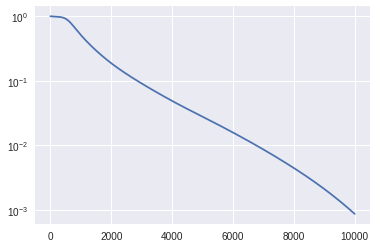

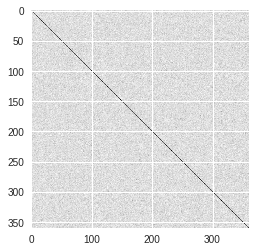

In [220]:
# train
auto_enc, train_loss, fishers, weights = train_and_get_fishers(data, lin_map, epochs=10000, init_gain = .05, lr=.1)
plt.semilogy(train_loss)

#make sure fisher is diagonal
fish = get_orientation_fisher(auto_enc,lin_map).detach().cpu().numpy()
plt.figure()
plt.imshow(fish)



In [225]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

In [226]:
import seaborn as sns

In [227]:
from matplotlib import cm

Text(0.5, 0, 'Orientation (deg)')

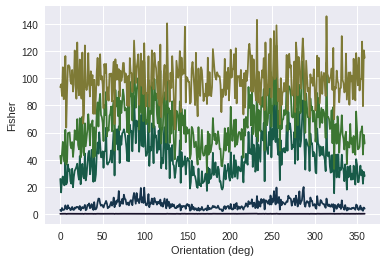

In [228]:
n = 10

epochs = fishers.shape[1]

colors = sns.color_palette("cubehelix",n)

# which_epochs = range(0,epochs,epochs//n)
which_epochs = [0,600,1200,2000,-1]

for i,e in enumerate(which_epochs):
    plt.plot(smooth(fishers[e,:],1), c = colors[i])
plt.ylabel("Fisher")
plt.xlabel("Orientation (deg)")

#### This does not depend on whether the init is orthogonal or Xavier uniform

(Repeat above but with init_method different)

### Now lets look at the evolution of the Fisher for specific orientation

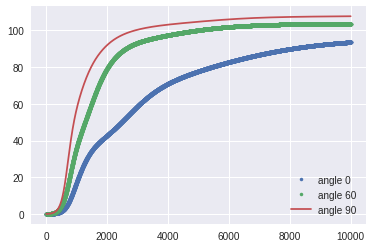

In [229]:
plt.plot(fishers[:,0], ".",label = "angle 0")
plt.plot(fishers[:,60],".", label = "angle 60")
plt.plot(fishers[:,90], label = "angle 90")
# plt.plot(fishers_numpy[:,120], label = "angle 120")
# plt.plot(fishers_numpy[:,180], label = "angle 180")


plt.legend()

#### Get the singular value spectrum of the inputs

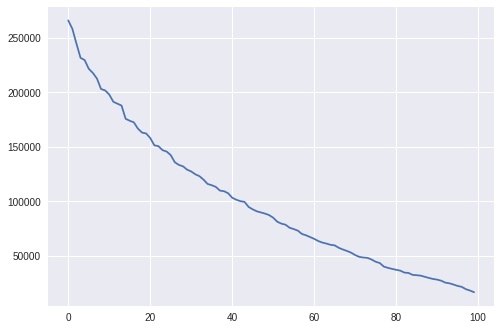

In [121]:
from scipy.linalg import svd

u, s, vh = svd(np.dot(data.T,data))
#np.isclose(u,vh.T)
plt.plot(s)

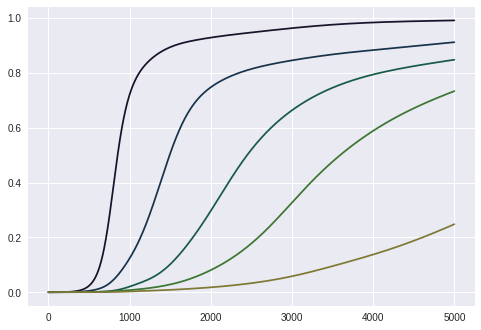

In [122]:
# how do the sv's change through timee?
weights_in_SV_space = [np.dot(w,u).T for w in weights]

for i,component in enumerate(range(0,100,20)):
    sizes_of_this_component = [np.dot(w[component],w[component]) for w in weights_in_SV_space]
    
    plt.plot(sizes_of_this_component, label = s[component], c=colors[i])


In [123]:
weights_in_SV_space[0].shape

(100, 500)

##### now let's see in the Fisher info is exactly what we think

Since we know how each principal component of the data is learned over time in the autoencoder weights (`l1`), the degree to which any one angle is learned over time is simply the sum of the principal components times the components in each angle.

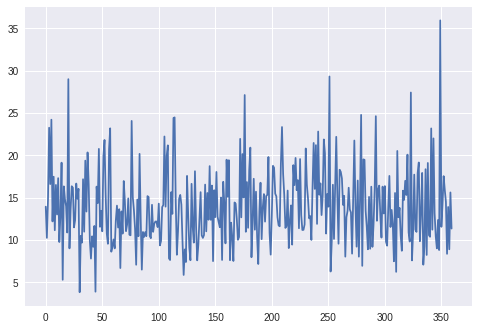

In [200]:
zva_ = np.dot(lin_map,np.dot(u,weights_in_SV_space[1200]))
plt.plot(np.diag(np.dot(zva_,zva_.T)))

### Does this depend on the mapping?

what if the orientation->inputs mapping is orthonormal?


In [198]:
data_orth = simulate_data(linear_mapping_ortho, prior, N=100000)

500 100
Epoch: 1 Train Loss: 1.114061 
Epoch: 2 Train Loss: 1.113985 
Epoch: 3 Train Loss: 1.113908 
Epoch: 4 Train Loss: 1.113833 
Epoch: 5 Train Loss: 1.113758 
Epoch: 6 Train Loss: 1.113683 
Epoch: 7 Train Loss: 1.113609 
Epoch: 8 Train Loss: 1.113535 
Epoch: 9 Train Loss: 1.113462 
Epoch: 10 Train Loss: 1.113389 
Epoch: 11 Train Loss: 1.113317 
Epoch: 12 Train Loss: 1.113245 
Epoch: 13 Train Loss: 1.113174 
Epoch: 14 Train Loss: 1.113103 
Epoch: 15 Train Loss: 1.113033 
Epoch: 16 Train Loss: 1.112963 
Epoch: 17 Train Loss: 1.112893 
Epoch: 18 Train Loss: 1.112824 
Epoch: 19 Train Loss: 1.112755 
Epoch: 20 Train Loss: 1.112687 
Epoch: 21 Train Loss: 1.112619 
Epoch: 22 Train Loss: 1.112551 
Epoch: 23 Train Loss: 1.112484 
Epoch: 24 Train Loss: 1.112417 
Epoch: 25 Train Loss: 1.112351 
Epoch: 26 Train Loss: 1.112285 
Epoch: 27 Train Loss: 1.112219 
Epoch: 28 Train Loss: 1.112154 
Epoch: 29 Train Loss: 1.112089 
Epoch: 30 Train Loss: 1.112024 
Epoch: 31 Train Loss: 1.111960 
Epoch: 32

Epoch: 267 Train Loss: 1.098486 
Epoch: 268 Train Loss: 1.098411 
Epoch: 269 Train Loss: 1.098337 
Epoch: 270 Train Loss: 1.098262 
Epoch: 271 Train Loss: 1.098186 
Epoch: 272 Train Loss: 1.098110 
Epoch: 273 Train Loss: 1.098034 
Epoch: 274 Train Loss: 1.097958 
Epoch: 275 Train Loss: 1.097881 
Epoch: 276 Train Loss: 1.097804 
Epoch: 277 Train Loss: 1.097726 
Epoch: 278 Train Loss: 1.097649 
Epoch: 279 Train Loss: 1.097570 
Epoch: 280 Train Loss: 1.097492 
Epoch: 281 Train Loss: 1.097413 
Epoch: 282 Train Loss: 1.097333 
Epoch: 283 Train Loss: 1.097254 
Epoch: 284 Train Loss: 1.097174 
Epoch: 285 Train Loss: 1.097093 
Epoch: 286 Train Loss: 1.097012 
Epoch: 287 Train Loss: 1.096931 
Epoch: 288 Train Loss: 1.096850 
Epoch: 289 Train Loss: 1.096768 
Epoch: 290 Train Loss: 1.096685 
Epoch: 291 Train Loss: 1.096602 
Epoch: 292 Train Loss: 1.096519 
Epoch: 293 Train Loss: 1.096436 
Epoch: 294 Train Loss: 1.096352 
Epoch: 295 Train Loss: 1.096267 
Epoch: 296 Train Loss: 1.096183 
Epoch: 297

Epoch: 523 Train Loss: 1.059006 
Epoch: 524 Train Loss: 1.058721 
Epoch: 525 Train Loss: 1.058435 
Epoch: 526 Train Loss: 1.058147 
Epoch: 527 Train Loss: 1.057857 
Epoch: 528 Train Loss: 1.057566 
Epoch: 529 Train Loss: 1.057274 
Epoch: 530 Train Loss: 1.056980 
Epoch: 531 Train Loss: 1.056684 
Epoch: 532 Train Loss: 1.056387 
Epoch: 533 Train Loss: 1.056088 
Epoch: 534 Train Loss: 1.055787 
Epoch: 535 Train Loss: 1.055485 
Epoch: 536 Train Loss: 1.055182 
Epoch: 537 Train Loss: 1.054876 
Epoch: 538 Train Loss: 1.054569 
Epoch: 539 Train Loss: 1.054261 
Epoch: 540 Train Loss: 1.053951 
Epoch: 541 Train Loss: 1.053639 
Epoch: 542 Train Loss: 1.053326 
Epoch: 543 Train Loss: 1.053011 
Epoch: 544 Train Loss: 1.052694 
Epoch: 545 Train Loss: 1.052375 
Epoch: 546 Train Loss: 1.052055 
Epoch: 547 Train Loss: 1.051733 
Epoch: 548 Train Loss: 1.051410 
Epoch: 549 Train Loss: 1.051085 
Epoch: 550 Train Loss: 1.050758 
Epoch: 551 Train Loss: 1.050429 
Epoch: 552 Train Loss: 1.050099 
Epoch: 553

Epoch: 776 Train Loss: 0.919133 
Epoch: 777 Train Loss: 0.918254 
Epoch: 778 Train Loss: 0.917372 
Epoch: 779 Train Loss: 0.916487 
Epoch: 780 Train Loss: 0.915600 
Epoch: 781 Train Loss: 0.914710 
Epoch: 782 Train Loss: 0.913817 
Epoch: 783 Train Loss: 0.912922 
Epoch: 784 Train Loss: 0.912025 
Epoch: 785 Train Loss: 0.911124 
Epoch: 786 Train Loss: 0.910221 
Epoch: 787 Train Loss: 0.909316 
Epoch: 788 Train Loss: 0.908407 
Epoch: 789 Train Loss: 0.907497 
Epoch: 790 Train Loss: 0.906583 
Epoch: 791 Train Loss: 0.905667 
Epoch: 792 Train Loss: 0.904749 
Epoch: 793 Train Loss: 0.903828 
Epoch: 794 Train Loss: 0.902904 
Epoch: 795 Train Loss: 0.901978 
Epoch: 796 Train Loss: 0.901050 
Epoch: 797 Train Loss: 0.900119 
Epoch: 798 Train Loss: 0.899185 
Epoch: 799 Train Loss: 0.898249 
Epoch: 800 Train Loss: 0.897310 
Epoch: 801 Train Loss: 0.896369 
Epoch: 802 Train Loss: 0.895426 
Epoch: 803 Train Loss: 0.894480 
Epoch: 804 Train Loss: 0.893531 
Epoch: 805 Train Loss: 0.892581 
Epoch: 806

Epoch: 1025 Train Loss: 0.650751 
Epoch: 1026 Train Loss: 0.649641 
Epoch: 1027 Train Loss: 0.648532 
Epoch: 1028 Train Loss: 0.647424 
Epoch: 1029 Train Loss: 0.646317 
Epoch: 1030 Train Loss: 0.645212 
Epoch: 1031 Train Loss: 0.644107 
Epoch: 1032 Train Loss: 0.643003 
Epoch: 1033 Train Loss: 0.641901 
Epoch: 1034 Train Loss: 0.640800 
Epoch: 1035 Train Loss: 0.639699 
Epoch: 1036 Train Loss: 0.638600 
Epoch: 1037 Train Loss: 0.637502 
Epoch: 1038 Train Loss: 0.636406 
Epoch: 1039 Train Loss: 0.635310 
Epoch: 1040 Train Loss: 0.634215 
Epoch: 1041 Train Loss: 0.633122 
Epoch: 1042 Train Loss: 0.632030 
Epoch: 1043 Train Loss: 0.630939 
Epoch: 1044 Train Loss: 0.629850 
Epoch: 1045 Train Loss: 0.628761 
Epoch: 1046 Train Loss: 0.627674 
Epoch: 1047 Train Loss: 0.626588 
Epoch: 1048 Train Loss: 0.625504 
Epoch: 1049 Train Loss: 0.624420 
Epoch: 1050 Train Loss: 0.623338 
Epoch: 1051 Train Loss: 0.622257 
Epoch: 1052 Train Loss: 0.621178 
Epoch: 1053 Train Loss: 0.620099 
Epoch: 1054 Tr

Epoch: 1277 Train Loss: 0.418712 
Epoch: 1278 Train Loss: 0.417996 
Epoch: 1279 Train Loss: 0.417282 
Epoch: 1280 Train Loss: 0.416569 
Epoch: 1281 Train Loss: 0.415857 
Epoch: 1282 Train Loss: 0.415147 
Epoch: 1283 Train Loss: 0.414439 
Epoch: 1284 Train Loss: 0.413732 
Epoch: 1285 Train Loss: 0.413026 
Epoch: 1286 Train Loss: 0.412322 
Epoch: 1287 Train Loss: 0.411620 
Epoch: 1288 Train Loss: 0.410919 
Epoch: 1289 Train Loss: 0.410219 
Epoch: 1290 Train Loss: 0.409521 
Epoch: 1291 Train Loss: 0.408824 
Epoch: 1292 Train Loss: 0.408129 
Epoch: 1293 Train Loss: 0.407435 
Epoch: 1294 Train Loss: 0.406743 
Epoch: 1295 Train Loss: 0.406052 
Epoch: 1296 Train Loss: 0.405363 
Epoch: 1297 Train Loss: 0.404674 
Epoch: 1298 Train Loss: 0.403988 
Epoch: 1299 Train Loss: 0.403303 
Epoch: 1300 Train Loss: 0.402619 
Epoch: 1301 Train Loss: 0.401937 
Epoch: 1302 Train Loss: 0.401256 
Epoch: 1303 Train Loss: 0.400576 
Epoch: 1304 Train Loss: 0.399898 
Epoch: 1305 Train Loss: 0.399222 
Epoch: 1306 Tr

Epoch: 1528 Train Loss: 0.278150 
Epoch: 1529 Train Loss: 0.277718 
Epoch: 1530 Train Loss: 0.277287 
Epoch: 1531 Train Loss: 0.276856 
Epoch: 1532 Train Loss: 0.276427 
Epoch: 1533 Train Loss: 0.275998 
Epoch: 1534 Train Loss: 0.275570 
Epoch: 1535 Train Loss: 0.275143 
Epoch: 1536 Train Loss: 0.274716 
Epoch: 1537 Train Loss: 0.274291 
Epoch: 1538 Train Loss: 0.273866 
Epoch: 1539 Train Loss: 0.273442 
Epoch: 1540 Train Loss: 0.273019 
Epoch: 1541 Train Loss: 0.272596 
Epoch: 1542 Train Loss: 0.272175 
Epoch: 1543 Train Loss: 0.271754 
Epoch: 1544 Train Loss: 0.271334 
Epoch: 1545 Train Loss: 0.270915 
Epoch: 1546 Train Loss: 0.270496 
Epoch: 1547 Train Loss: 0.270078 
Epoch: 1548 Train Loss: 0.269661 
Epoch: 1549 Train Loss: 0.269245 
Epoch: 1550 Train Loss: 0.268830 
Epoch: 1551 Train Loss: 0.268415 
Epoch: 1552 Train Loss: 0.268001 
Epoch: 1553 Train Loss: 0.267588 
Epoch: 1554 Train Loss: 0.267176 
Epoch: 1555 Train Loss: 0.266764 
Epoch: 1556 Train Loss: 0.266354 
Epoch: 1557 Tr

Epoch: 1781 Train Loss: 0.190264 
Epoch: 1782 Train Loss: 0.189987 
Epoch: 1783 Train Loss: 0.189710 
Epoch: 1784 Train Loss: 0.189434 
Epoch: 1785 Train Loss: 0.189159 
Epoch: 1786 Train Loss: 0.188884 
Epoch: 1787 Train Loss: 0.188609 
Epoch: 1788 Train Loss: 0.188335 
Epoch: 1789 Train Loss: 0.188061 
Epoch: 1790 Train Loss: 0.187788 
Epoch: 1791 Train Loss: 0.187515 
Epoch: 1792 Train Loss: 0.187243 
Epoch: 1793 Train Loss: 0.186971 
Epoch: 1794 Train Loss: 0.186699 
Epoch: 1795 Train Loss: 0.186428 
Epoch: 1796 Train Loss: 0.186158 
Epoch: 1797 Train Loss: 0.185888 
Epoch: 1798 Train Loss: 0.185618 
Epoch: 1799 Train Loss: 0.185349 
Epoch: 1800 Train Loss: 0.185080 
Epoch: 1801 Train Loss: 0.184812 
Epoch: 1802 Train Loss: 0.184544 
Epoch: 1803 Train Loss: 0.184276 
Epoch: 1804 Train Loss: 0.184009 
Epoch: 1805 Train Loss: 0.183743 
Epoch: 1806 Train Loss: 0.183476 
Epoch: 1807 Train Loss: 0.183211 
Epoch: 1808 Train Loss: 0.182945 
Epoch: 1809 Train Loss: 0.182681 
Epoch: 1810 Tr

Epoch: 2033 Train Loss: 0.132868 
Epoch: 2034 Train Loss: 0.132682 
Epoch: 2035 Train Loss: 0.132497 
Epoch: 2036 Train Loss: 0.132312 
Epoch: 2037 Train Loss: 0.132128 
Epoch: 2038 Train Loss: 0.131943 
Epoch: 2039 Train Loss: 0.131759 
Epoch: 2040 Train Loss: 0.131576 
Epoch: 2041 Train Loss: 0.131392 
Epoch: 2042 Train Loss: 0.131209 
Epoch: 2043 Train Loss: 0.131026 
Epoch: 2044 Train Loss: 0.130844 
Epoch: 2045 Train Loss: 0.130661 
Epoch: 2046 Train Loss: 0.130479 
Epoch: 2047 Train Loss: 0.130297 
Epoch: 2048 Train Loss: 0.130116 
Epoch: 2049 Train Loss: 0.129935 
Epoch: 2050 Train Loss: 0.129754 
Epoch: 2051 Train Loss: 0.129573 
Epoch: 2052 Train Loss: 0.129393 
Epoch: 2053 Train Loss: 0.129213 
Epoch: 2054 Train Loss: 0.129033 
Epoch: 2055 Train Loss: 0.128853 
Epoch: 2056 Train Loss: 0.128674 
Epoch: 2057 Train Loss: 0.128495 
Epoch: 2058 Train Loss: 0.128316 
Epoch: 2059 Train Loss: 0.128138 
Epoch: 2060 Train Loss: 0.127960 
Epoch: 2061 Train Loss: 0.127782 
Epoch: 2062 Tr

Epoch: 2285 Train Loss: 0.093988 
Epoch: 2286 Train Loss: 0.093861 
Epoch: 2287 Train Loss: 0.093734 
Epoch: 2288 Train Loss: 0.093608 
Epoch: 2289 Train Loss: 0.093481 
Epoch: 2290 Train Loss: 0.093355 
Epoch: 2291 Train Loss: 0.093228 
Epoch: 2292 Train Loss: 0.093102 
Epoch: 2293 Train Loss: 0.092977 
Epoch: 2294 Train Loss: 0.092851 
Epoch: 2295 Train Loss: 0.092726 
Epoch: 2296 Train Loss: 0.092600 
Epoch: 2297 Train Loss: 0.092475 
Epoch: 2298 Train Loss: 0.092350 
Epoch: 2299 Train Loss: 0.092225 
Epoch: 2300 Train Loss: 0.092101 
Epoch: 2301 Train Loss: 0.091977 
Epoch: 2302 Train Loss: 0.091852 
Epoch: 2303 Train Loss: 0.091728 
Epoch: 2304 Train Loss: 0.091604 
Epoch: 2305 Train Loss: 0.091481 
Epoch: 2306 Train Loss: 0.091357 
Epoch: 2307 Train Loss: 0.091234 
Epoch: 2308 Train Loss: 0.091111 
Epoch: 2309 Train Loss: 0.090988 
Epoch: 2310 Train Loss: 0.090865 
Epoch: 2311 Train Loss: 0.090743 
Epoch: 2312 Train Loss: 0.090620 
Epoch: 2313 Train Loss: 0.090498 
Epoch: 2314 Tr

Epoch: 2536 Train Loss: 0.067139 
Epoch: 2537 Train Loss: 0.067050 
Epoch: 2538 Train Loss: 0.066960 
Epoch: 2539 Train Loss: 0.066871 
Epoch: 2540 Train Loss: 0.066782 
Epoch: 2541 Train Loss: 0.066694 
Epoch: 2542 Train Loss: 0.066605 
Epoch: 2543 Train Loss: 0.066516 
Epoch: 2544 Train Loss: 0.066428 
Epoch: 2545 Train Loss: 0.066339 
Epoch: 2546 Train Loss: 0.066251 
Epoch: 2547 Train Loss: 0.066163 
Epoch: 2548 Train Loss: 0.066075 
Epoch: 2549 Train Loss: 0.065987 
Epoch: 2550 Train Loss: 0.065900 
Epoch: 2551 Train Loss: 0.065812 
Epoch: 2552 Train Loss: 0.065724 
Epoch: 2553 Train Loss: 0.065637 
Epoch: 2554 Train Loss: 0.065550 
Epoch: 2555 Train Loss: 0.065463 
Epoch: 2556 Train Loss: 0.065376 
Epoch: 2557 Train Loss: 0.065289 
Epoch: 2558 Train Loss: 0.065202 
Epoch: 2559 Train Loss: 0.065115 
Epoch: 2560 Train Loss: 0.065029 
Epoch: 2561 Train Loss: 0.064942 
Epoch: 2562 Train Loss: 0.064856 
Epoch: 2563 Train Loss: 0.064770 
Epoch: 2564 Train Loss: 0.064684 
Epoch: 2565 Tr

Epoch: 2787 Train Loss: 0.048085 
Epoch: 2788 Train Loss: 0.048021 
Epoch: 2789 Train Loss: 0.047957 
Epoch: 2790 Train Loss: 0.047894 
Epoch: 2791 Train Loss: 0.047830 
Epoch: 2792 Train Loss: 0.047766 
Epoch: 2793 Train Loss: 0.047702 
Epoch: 2794 Train Loss: 0.047639 
Epoch: 2795 Train Loss: 0.047575 
Epoch: 2796 Train Loss: 0.047512 
Epoch: 2797 Train Loss: 0.047449 
Epoch: 2798 Train Loss: 0.047386 
Epoch: 2799 Train Loss: 0.047322 
Epoch: 2800 Train Loss: 0.047259 
Epoch: 2801 Train Loss: 0.047196 
Epoch: 2802 Train Loss: 0.047134 
Epoch: 2803 Train Loss: 0.047071 
Epoch: 2804 Train Loss: 0.047008 
Epoch: 2805 Train Loss: 0.046945 
Epoch: 2806 Train Loss: 0.046883 
Epoch: 2807 Train Loss: 0.046820 
Epoch: 2808 Train Loss: 0.046758 
Epoch: 2809 Train Loss: 0.046696 
Epoch: 2810 Train Loss: 0.046633 
Epoch: 2811 Train Loss: 0.046571 
Epoch: 2812 Train Loss: 0.046509 
Epoch: 2813 Train Loss: 0.046447 
Epoch: 2814 Train Loss: 0.046385 
Epoch: 2815 Train Loss: 0.046323 
Epoch: 2816 Tr

Epoch: 3038 Train Loss: 0.034320 
Epoch: 3039 Train Loss: 0.034273 
Epoch: 3040 Train Loss: 0.034227 
Epoch: 3041 Train Loss: 0.034180 
Epoch: 3042 Train Loss: 0.034134 
Epoch: 3043 Train Loss: 0.034088 
Epoch: 3044 Train Loss: 0.034041 
Epoch: 3045 Train Loss: 0.033995 
Epoch: 3046 Train Loss: 0.033949 
Epoch: 3047 Train Loss: 0.033903 
Epoch: 3048 Train Loss: 0.033857 
Epoch: 3049 Train Loss: 0.033811 
Epoch: 3050 Train Loss: 0.033765 
Epoch: 3051 Train Loss: 0.033719 
Epoch: 3052 Train Loss: 0.033673 
Epoch: 3053 Train Loss: 0.033627 
Epoch: 3054 Train Loss: 0.033581 
Epoch: 3055 Train Loss: 0.033536 
Epoch: 3056 Train Loss: 0.033490 
Epoch: 3057 Train Loss: 0.033444 
Epoch: 3058 Train Loss: 0.033399 
Epoch: 3059 Train Loss: 0.033353 
Epoch: 3060 Train Loss: 0.033308 
Epoch: 3061 Train Loss: 0.033263 
Epoch: 3062 Train Loss: 0.033217 
Epoch: 3063 Train Loss: 0.033172 
Epoch: 3064 Train Loss: 0.033127 
Epoch: 3065 Train Loss: 0.033082 
Epoch: 3066 Train Loss: 0.033037 
Epoch: 3067 Tr

Epoch: 3286 Train Loss: 0.024360 
Epoch: 3287 Train Loss: 0.024326 
Epoch: 3288 Train Loss: 0.024291 
Epoch: 3289 Train Loss: 0.024257 
Epoch: 3290 Train Loss: 0.024223 
Epoch: 3291 Train Loss: 0.024189 
Epoch: 3292 Train Loss: 0.024155 
Epoch: 3293 Train Loss: 0.024121 
Epoch: 3294 Train Loss: 0.024086 
Epoch: 3295 Train Loss: 0.024053 
Epoch: 3296 Train Loss: 0.024019 
Epoch: 3297 Train Loss: 0.023985 
Epoch: 3298 Train Loss: 0.023951 
Epoch: 3299 Train Loss: 0.023917 
Epoch: 3300 Train Loss: 0.023883 
Epoch: 3301 Train Loss: 0.023850 
Epoch: 3302 Train Loss: 0.023816 
Epoch: 3303 Train Loss: 0.023782 
Epoch: 3304 Train Loss: 0.023749 
Epoch: 3305 Train Loss: 0.023715 
Epoch: 3306 Train Loss: 0.023681 
Epoch: 3307 Train Loss: 0.023648 
Epoch: 3308 Train Loss: 0.023615 
Epoch: 3309 Train Loss: 0.023581 
Epoch: 3310 Train Loss: 0.023548 
Epoch: 3311 Train Loss: 0.023515 
Epoch: 3312 Train Loss: 0.023481 
Epoch: 3313 Train Loss: 0.023448 
Epoch: 3314 Train Loss: 0.023415 
Epoch: 3315 Tr

Epoch: 3537 Train Loss: 0.016952 
Epoch: 3538 Train Loss: 0.016927 
Epoch: 3539 Train Loss: 0.016902 
Epoch: 3540 Train Loss: 0.016877 
Epoch: 3541 Train Loss: 0.016852 
Epoch: 3542 Train Loss: 0.016827 
Epoch: 3543 Train Loss: 0.016802 
Epoch: 3544 Train Loss: 0.016777 
Epoch: 3545 Train Loss: 0.016752 
Epoch: 3546 Train Loss: 0.016727 
Epoch: 3547 Train Loss: 0.016702 
Epoch: 3548 Train Loss: 0.016678 
Epoch: 3549 Train Loss: 0.016653 
Epoch: 3550 Train Loss: 0.016628 
Epoch: 3551 Train Loss: 0.016603 
Epoch: 3552 Train Loss: 0.016579 
Epoch: 3553 Train Loss: 0.016554 
Epoch: 3554 Train Loss: 0.016529 
Epoch: 3555 Train Loss: 0.016505 
Epoch: 3556 Train Loss: 0.016480 
Epoch: 3557 Train Loss: 0.016456 
Epoch: 3558 Train Loss: 0.016431 
Epoch: 3559 Train Loss: 0.016407 
Epoch: 3560 Train Loss: 0.016382 
Epoch: 3561 Train Loss: 0.016358 
Epoch: 3562 Train Loss: 0.016334 
Epoch: 3563 Train Loss: 0.016309 
Epoch: 3564 Train Loss: 0.016285 
Epoch: 3565 Train Loss: 0.016261 
Epoch: 3566 Tr

Epoch: 3789 Train Loss: 0.011546 
Epoch: 3790 Train Loss: 0.011528 
Epoch: 3791 Train Loss: 0.011510 
Epoch: 3792 Train Loss: 0.011492 
Epoch: 3793 Train Loss: 0.011474 
Epoch: 3794 Train Loss: 0.011456 
Epoch: 3795 Train Loss: 0.011438 
Epoch: 3796 Train Loss: 0.011420 
Epoch: 3797 Train Loss: 0.011402 
Epoch: 3798 Train Loss: 0.011384 
Epoch: 3799 Train Loss: 0.011366 
Epoch: 3800 Train Loss: 0.011348 
Epoch: 3801 Train Loss: 0.011330 
Epoch: 3802 Train Loss: 0.011313 
Epoch: 3803 Train Loss: 0.011295 
Epoch: 3804 Train Loss: 0.011277 
Epoch: 3805 Train Loss: 0.011259 
Epoch: 3806 Train Loss: 0.011242 
Epoch: 3807 Train Loss: 0.011224 
Epoch: 3808 Train Loss: 0.011206 
Epoch: 3809 Train Loss: 0.011189 
Epoch: 3810 Train Loss: 0.011171 
Epoch: 3811 Train Loss: 0.011154 
Epoch: 3812 Train Loss: 0.011136 
Epoch: 3813 Train Loss: 0.011119 
Epoch: 3814 Train Loss: 0.011101 
Epoch: 3815 Train Loss: 0.011084 
Epoch: 3816 Train Loss: 0.011066 
Epoch: 3817 Train Loss: 0.011049 
Epoch: 3818 Tr

Epoch: 4040 Train Loss: 0.007712 
Epoch: 4041 Train Loss: 0.007699 
Epoch: 4042 Train Loss: 0.007687 
Epoch: 4043 Train Loss: 0.007674 
Epoch: 4044 Train Loss: 0.007661 
Epoch: 4045 Train Loss: 0.007649 
Epoch: 4046 Train Loss: 0.007636 
Epoch: 4047 Train Loss: 0.007624 
Epoch: 4048 Train Loss: 0.007611 
Epoch: 4049 Train Loss: 0.007598 
Epoch: 4050 Train Loss: 0.007586 
Epoch: 4051 Train Loss: 0.007573 
Epoch: 4052 Train Loss: 0.007561 
Epoch: 4053 Train Loss: 0.007548 
Epoch: 4054 Train Loss: 0.007536 
Epoch: 4055 Train Loss: 0.007524 
Epoch: 4056 Train Loss: 0.007511 
Epoch: 4057 Train Loss: 0.007499 
Epoch: 4058 Train Loss: 0.007486 
Epoch: 4059 Train Loss: 0.007474 
Epoch: 4060 Train Loss: 0.007462 
Epoch: 4061 Train Loss: 0.007449 
Epoch: 4062 Train Loss: 0.007437 
Epoch: 4063 Train Loss: 0.007425 
Epoch: 4064 Train Loss: 0.007413 
Epoch: 4065 Train Loss: 0.007400 
Epoch: 4066 Train Loss: 0.007388 
Epoch: 4067 Train Loss: 0.007376 
Epoch: 4068 Train Loss: 0.007364 
Epoch: 4069 Tr

Epoch: 4290 Train Loss: 0.005069 
Epoch: 4291 Train Loss: 0.005060 
Epoch: 4292 Train Loss: 0.005052 
Epoch: 4293 Train Loss: 0.005043 
Epoch: 4294 Train Loss: 0.005034 
Epoch: 4295 Train Loss: 0.005026 
Epoch: 4296 Train Loss: 0.005017 
Epoch: 4297 Train Loss: 0.005009 
Epoch: 4298 Train Loss: 0.005000 
Epoch: 4299 Train Loss: 0.004992 
Epoch: 4300 Train Loss: 0.004983 
Epoch: 4301 Train Loss: 0.004975 
Epoch: 4302 Train Loss: 0.004966 
Epoch: 4303 Train Loss: 0.004958 
Epoch: 4304 Train Loss: 0.004949 
Epoch: 4305 Train Loss: 0.004941 
Epoch: 4306 Train Loss: 0.004932 
Epoch: 4307 Train Loss: 0.004924 
Epoch: 4308 Train Loss: 0.004915 
Epoch: 4309 Train Loss: 0.004907 
Epoch: 4310 Train Loss: 0.004899 
Epoch: 4311 Train Loss: 0.004890 
Epoch: 4312 Train Loss: 0.004882 
Epoch: 4313 Train Loss: 0.004874 
Epoch: 4314 Train Loss: 0.004865 
Epoch: 4315 Train Loss: 0.004857 
Epoch: 4316 Train Loss: 0.004849 
Epoch: 4317 Train Loss: 0.004840 
Epoch: 4318 Train Loss: 0.004832 
Epoch: 4319 Tr

Epoch: 4540 Train Loss: 0.003292 
Epoch: 4541 Train Loss: 0.003286 
Epoch: 4542 Train Loss: 0.003281 
Epoch: 4543 Train Loss: 0.003275 
Epoch: 4544 Train Loss: 0.003269 
Epoch: 4545 Train Loss: 0.003264 
Epoch: 4546 Train Loss: 0.003258 
Epoch: 4547 Train Loss: 0.003252 
Epoch: 4548 Train Loss: 0.003247 
Epoch: 4549 Train Loss: 0.003241 
Epoch: 4550 Train Loss: 0.003235 
Epoch: 4551 Train Loss: 0.003230 
Epoch: 4552 Train Loss: 0.003224 
Epoch: 4553 Train Loss: 0.003218 
Epoch: 4554 Train Loss: 0.003213 
Epoch: 4555 Train Loss: 0.003207 
Epoch: 4556 Train Loss: 0.003202 
Epoch: 4557 Train Loss: 0.003196 
Epoch: 4558 Train Loss: 0.003190 
Epoch: 4559 Train Loss: 0.003185 
Epoch: 4560 Train Loss: 0.003179 
Epoch: 4561 Train Loss: 0.003174 
Epoch: 4562 Train Loss: 0.003168 
Epoch: 4563 Train Loss: 0.003163 
Epoch: 4564 Train Loss: 0.003157 
Epoch: 4565 Train Loss: 0.003152 
Epoch: 4566 Train Loss: 0.003146 
Epoch: 4567 Train Loss: 0.003141 
Epoch: 4568 Train Loss: 0.003135 
Epoch: 4569 Tr

Epoch: 4790 Train Loss: 0.002123 
Epoch: 4791 Train Loss: 0.002119 
Epoch: 4792 Train Loss: 0.002115 
Epoch: 4793 Train Loss: 0.002112 
Epoch: 4794 Train Loss: 0.002108 
Epoch: 4795 Train Loss: 0.002104 
Epoch: 4796 Train Loss: 0.002101 
Epoch: 4797 Train Loss: 0.002097 
Epoch: 4798 Train Loss: 0.002093 
Epoch: 4799 Train Loss: 0.002089 
Epoch: 4800 Train Loss: 0.002086 
Epoch: 4801 Train Loss: 0.002082 
Epoch: 4802 Train Loss: 0.002078 
Epoch: 4803 Train Loss: 0.002075 
Epoch: 4804 Train Loss: 0.002071 
Epoch: 4805 Train Loss: 0.002067 
Epoch: 4806 Train Loss: 0.002064 
Epoch: 4807 Train Loss: 0.002060 
Epoch: 4808 Train Loss: 0.002056 
Epoch: 4809 Train Loss: 0.002053 
Epoch: 4810 Train Loss: 0.002049 
Epoch: 4811 Train Loss: 0.002046 
Epoch: 4812 Train Loss: 0.002042 
Epoch: 4813 Train Loss: 0.002038 
Epoch: 4814 Train Loss: 0.002035 
Epoch: 4815 Train Loss: 0.002031 
Epoch: 4816 Train Loss: 0.002028 
Epoch: 4817 Train Loss: 0.002024 
Epoch: 4818 Train Loss: 0.002020 
Epoch: 4819 Tr

Epoch: 5031 Train Loss: 0.001382 
Epoch: 5032 Train Loss: 0.001380 
Epoch: 5033 Train Loss: 0.001377 
Epoch: 5034 Train Loss: 0.001375 
Epoch: 5035 Train Loss: 0.001372 
Epoch: 5036 Train Loss: 0.001370 
Epoch: 5037 Train Loss: 0.001368 
Epoch: 5038 Train Loss: 0.001365 
Epoch: 5039 Train Loss: 0.001363 
Epoch: 5040 Train Loss: 0.001360 
Epoch: 5041 Train Loss: 0.001358 
Epoch: 5042 Train Loss: 0.001355 
Epoch: 5043 Train Loss: 0.001353 
Epoch: 5044 Train Loss: 0.001350 
Epoch: 5045 Train Loss: 0.001348 
Epoch: 5046 Train Loss: 0.001346 
Epoch: 5047 Train Loss: 0.001343 
Epoch: 5048 Train Loss: 0.001341 
Epoch: 5049 Train Loss: 0.001338 
Epoch: 5050 Train Loss: 0.001336 
Epoch: 5051 Train Loss: 0.001334 
Epoch: 5052 Train Loss: 0.001331 
Epoch: 5053 Train Loss: 0.001329 
Epoch: 5054 Train Loss: 0.001326 
Epoch: 5055 Train Loss: 0.001324 
Epoch: 5056 Train Loss: 0.001322 
Epoch: 5057 Train Loss: 0.001319 
Epoch: 5058 Train Loss: 0.001317 
Epoch: 5059 Train Loss: 0.001314 
Epoch: 5060 Tr

Epoch: 5272 Train Loss: 0.000892 
Epoch: 5273 Train Loss: 0.000890 
Epoch: 5274 Train Loss: 0.000889 
Epoch: 5275 Train Loss: 0.000887 
Epoch: 5276 Train Loss: 0.000885 
Epoch: 5277 Train Loss: 0.000884 
Epoch: 5278 Train Loss: 0.000882 
Epoch: 5279 Train Loss: 0.000880 
Epoch: 5280 Train Loss: 0.000879 
Epoch: 5281 Train Loss: 0.000877 
Epoch: 5282 Train Loss: 0.000876 
Epoch: 5283 Train Loss: 0.000874 
Epoch: 5284 Train Loss: 0.000872 
Epoch: 5285 Train Loss: 0.000871 
Epoch: 5286 Train Loss: 0.000869 
Epoch: 5287 Train Loss: 0.000867 
Epoch: 5288 Train Loss: 0.000866 
Epoch: 5289 Train Loss: 0.000864 
Epoch: 5290 Train Loss: 0.000863 
Epoch: 5291 Train Loss: 0.000861 
Epoch: 5292 Train Loss: 0.000859 
Epoch: 5293 Train Loss: 0.000858 
Epoch: 5294 Train Loss: 0.000856 
Epoch: 5295 Train Loss: 0.000855 
Epoch: 5296 Train Loss: 0.000853 
Epoch: 5297 Train Loss: 0.000852 
Epoch: 5298 Train Loss: 0.000850 
Epoch: 5299 Train Loss: 0.000848 
Epoch: 5300 Train Loss: 0.000847 
Epoch: 5301 Tr

Epoch: 5531 Train Loss: 0.000548 
Epoch: 5532 Train Loss: 0.000547 
Epoch: 5533 Train Loss: 0.000546 
Epoch: 5534 Train Loss: 0.000545 
Epoch: 5535 Train Loss: 0.000544 
Epoch: 5536 Train Loss: 0.000543 
Epoch: 5537 Train Loss: 0.000542 
Epoch: 5538 Train Loss: 0.000541 
Epoch: 5539 Train Loss: 0.000540 
Epoch: 5540 Train Loss: 0.000539 
Epoch: 5541 Train Loss: 0.000538 
Epoch: 5542 Train Loss: 0.000537 
Epoch: 5543 Train Loss: 0.000535 
Epoch: 5544 Train Loss: 0.000534 
Epoch: 5545 Train Loss: 0.000533 
Epoch: 5546 Train Loss: 0.000532 
Epoch: 5547 Train Loss: 0.000531 
Epoch: 5548 Train Loss: 0.000530 
Epoch: 5549 Train Loss: 0.000529 
Epoch: 5550 Train Loss: 0.000528 
Epoch: 5551 Train Loss: 0.000527 
Epoch: 5552 Train Loss: 0.000526 
Epoch: 5553 Train Loss: 0.000525 
Epoch: 5554 Train Loss: 0.000524 
Epoch: 5555 Train Loss: 0.000523 
Epoch: 5556 Train Loss: 0.000522 
Epoch: 5557 Train Loss: 0.000521 
Epoch: 5558 Train Loss: 0.000520 
Epoch: 5559 Train Loss: 0.000519 
Epoch: 5560 Tr

Epoch: 5784 Train Loss: 0.000334 
Epoch: 5785 Train Loss: 0.000333 
Epoch: 5786 Train Loss: 0.000332 
Epoch: 5787 Train Loss: 0.000332 
Epoch: 5788 Train Loss: 0.000331 
Epoch: 5789 Train Loss: 0.000330 
Epoch: 5790 Train Loss: 0.000330 
Epoch: 5791 Train Loss: 0.000329 
Epoch: 5792 Train Loss: 0.000328 
Epoch: 5793 Train Loss: 0.000328 
Epoch: 5794 Train Loss: 0.000327 
Epoch: 5795 Train Loss: 0.000326 
Epoch: 5796 Train Loss: 0.000326 
Epoch: 5797 Train Loss: 0.000325 
Epoch: 5798 Train Loss: 0.000324 
Epoch: 5799 Train Loss: 0.000324 
Epoch: 5800 Train Loss: 0.000323 
Epoch: 5801 Train Loss: 0.000322 
Epoch: 5802 Train Loss: 0.000322 
Epoch: 5803 Train Loss: 0.000321 
Epoch: 5804 Train Loss: 0.000320 
Epoch: 5805 Train Loss: 0.000320 
Epoch: 5806 Train Loss: 0.000319 
Epoch: 5807 Train Loss: 0.000318 
Epoch: 5808 Train Loss: 0.000318 
Epoch: 5809 Train Loss: 0.000317 
Epoch: 5810 Train Loss: 0.000317 
Epoch: 5811 Train Loss: 0.000316 
Epoch: 5812 Train Loss: 0.000315 
Epoch: 5813 Tr

Epoch: 6038 Train Loss: 0.000198 
Epoch: 6039 Train Loss: 0.000198 
Epoch: 6040 Train Loss: 0.000197 
Epoch: 6041 Train Loss: 0.000197 
Epoch: 6042 Train Loss: 0.000196 
Epoch: 6043 Train Loss: 0.000196 
Epoch: 6044 Train Loss: 0.000196 
Epoch: 6045 Train Loss: 0.000195 
Epoch: 6046 Train Loss: 0.000195 
Epoch: 6047 Train Loss: 0.000194 
Epoch: 6048 Train Loss: 0.000194 
Epoch: 6049 Train Loss: 0.000193 
Epoch: 6050 Train Loss: 0.000193 
Epoch: 6051 Train Loss: 0.000193 
Epoch: 6052 Train Loss: 0.000192 
Epoch: 6053 Train Loss: 0.000192 
Epoch: 6054 Train Loss: 0.000191 
Epoch: 6055 Train Loss: 0.000191 
Epoch: 6056 Train Loss: 0.000191 
Epoch: 6057 Train Loss: 0.000190 
Epoch: 6058 Train Loss: 0.000190 
Epoch: 6059 Train Loss: 0.000189 
Epoch: 6060 Train Loss: 0.000189 
Epoch: 6061 Train Loss: 0.000189 
Epoch: 6062 Train Loss: 0.000188 
Epoch: 6063 Train Loss: 0.000188 
Epoch: 6064 Train Loss: 0.000187 
Epoch: 6065 Train Loss: 0.000187 
Epoch: 6066 Train Loss: 0.000187 
Epoch: 6067 Tr

Epoch: 6295 Train Loss: 0.000114 
Epoch: 6296 Train Loss: 0.000114 
Epoch: 6297 Train Loss: 0.000114 
Epoch: 6298 Train Loss: 0.000113 
Epoch: 6299 Train Loss: 0.000113 
Epoch: 6300 Train Loss: 0.000113 
Epoch: 6301 Train Loss: 0.000113 
Epoch: 6302 Train Loss: 0.000112 
Epoch: 6303 Train Loss: 0.000112 
Epoch: 6304 Train Loss: 0.000112 
Epoch: 6305 Train Loss: 0.000112 
Epoch: 6306 Train Loss: 0.000111 
Epoch: 6307 Train Loss: 0.000111 
Epoch: 6308 Train Loss: 0.000111 
Epoch: 6309 Train Loss: 0.000111 
Epoch: 6310 Train Loss: 0.000111 
Epoch: 6311 Train Loss: 0.000110 
Epoch: 6312 Train Loss: 0.000110 
Epoch: 6313 Train Loss: 0.000110 
Epoch: 6314 Train Loss: 0.000110 
Epoch: 6315 Train Loss: 0.000109 
Epoch: 6316 Train Loss: 0.000109 
Epoch: 6317 Train Loss: 0.000109 
Epoch: 6318 Train Loss: 0.000109 
Epoch: 6319 Train Loss: 0.000108 
Epoch: 6320 Train Loss: 0.000108 
Epoch: 6321 Train Loss: 0.000108 
Epoch: 6322 Train Loss: 0.000108 
Epoch: 6323 Train Loss: 0.000107 
Epoch: 6324 Tr

Epoch: 6552 Train Loss: 0.000065 
Epoch: 6553 Train Loss: 0.000064 
Epoch: 6554 Train Loss: 0.000064 
Epoch: 6555 Train Loss: 0.000064 
Epoch: 6556 Train Loss: 0.000064 
Epoch: 6557 Train Loss: 0.000064 
Epoch: 6558 Train Loss: 0.000064 
Epoch: 6559 Train Loss: 0.000064 
Epoch: 6560 Train Loss: 0.000063 
Epoch: 6561 Train Loss: 0.000063 
Epoch: 6562 Train Loss: 0.000063 
Epoch: 6563 Train Loss: 0.000063 
Epoch: 6564 Train Loss: 0.000063 
Epoch: 6565 Train Loss: 0.000063 
Epoch: 6566 Train Loss: 0.000063 
Epoch: 6567 Train Loss: 0.000062 
Epoch: 6568 Train Loss: 0.000062 
Epoch: 6569 Train Loss: 0.000062 
Epoch: 6570 Train Loss: 0.000062 
Epoch: 6571 Train Loss: 0.000062 
Epoch: 6572 Train Loss: 0.000062 
Epoch: 6573 Train Loss: 0.000062 
Epoch: 6574 Train Loss: 0.000061 
Epoch: 6575 Train Loss: 0.000061 
Epoch: 6576 Train Loss: 0.000061 
Epoch: 6577 Train Loss: 0.000061 
Epoch: 6578 Train Loss: 0.000061 
Epoch: 6579 Train Loss: 0.000061 
Epoch: 6580 Train Loss: 0.000061 
Epoch: 6581 Tr

Epoch: 6812 Train Loss: 0.000036 
Epoch: 6813 Train Loss: 0.000036 
Epoch: 6814 Train Loss: 0.000035 
Epoch: 6815 Train Loss: 0.000035 
Epoch: 6816 Train Loss: 0.000035 
Epoch: 6817 Train Loss: 0.000035 
Epoch: 6818 Train Loss: 0.000035 
Epoch: 6819 Train Loss: 0.000035 
Epoch: 6820 Train Loss: 0.000035 
Epoch: 6821 Train Loss: 0.000035 
Epoch: 6822 Train Loss: 0.000035 
Epoch: 6823 Train Loss: 0.000035 
Epoch: 6824 Train Loss: 0.000035 
Epoch: 6825 Train Loss: 0.000035 
Epoch: 6826 Train Loss: 0.000034 
Epoch: 6827 Train Loss: 0.000034 
Epoch: 6828 Train Loss: 0.000034 
Epoch: 6829 Train Loss: 0.000034 
Epoch: 6830 Train Loss: 0.000034 
Epoch: 6831 Train Loss: 0.000034 
Epoch: 6832 Train Loss: 0.000034 
Epoch: 6833 Train Loss: 0.000034 
Epoch: 6834 Train Loss: 0.000034 
Epoch: 6835 Train Loss: 0.000034 
Epoch: 6836 Train Loss: 0.000034 
Epoch: 6837 Train Loss: 0.000034 
Epoch: 6838 Train Loss: 0.000034 
Epoch: 6839 Train Loss: 0.000033 
Epoch: 6840 Train Loss: 0.000033 
Epoch: 6841 Tr

Epoch: 7072 Train Loss: 0.000019 
Epoch: 7073 Train Loss: 0.000019 
Epoch: 7074 Train Loss: 0.000019 
Epoch: 7075 Train Loss: 0.000019 
Epoch: 7076 Train Loss: 0.000019 
Epoch: 7077 Train Loss: 0.000019 
Epoch: 7078 Train Loss: 0.000019 
Epoch: 7079 Train Loss: 0.000019 
Epoch: 7080 Train Loss: 0.000019 
Epoch: 7081 Train Loss: 0.000019 
Epoch: 7082 Train Loss: 0.000019 
Epoch: 7083 Train Loss: 0.000019 
Epoch: 7084 Train Loss: 0.000019 
Epoch: 7085 Train Loss: 0.000019 
Epoch: 7086 Train Loss: 0.000019 
Epoch: 7087 Train Loss: 0.000019 
Epoch: 7088 Train Loss: 0.000019 
Epoch: 7089 Train Loss: 0.000019 
Epoch: 7090 Train Loss: 0.000019 
Epoch: 7091 Train Loss: 0.000019 
Epoch: 7092 Train Loss: 0.000018 
Epoch: 7093 Train Loss: 0.000018 
Epoch: 7094 Train Loss: 0.000018 
Epoch: 7095 Train Loss: 0.000018 
Epoch: 7096 Train Loss: 0.000018 
Epoch: 7097 Train Loss: 0.000018 
Epoch: 7098 Train Loss: 0.000018 
Epoch: 7099 Train Loss: 0.000018 
Epoch: 7100 Train Loss: 0.000018 
Epoch: 7101 Tr

Epoch: 7329 Train Loss: 0.000011 
Epoch: 7330 Train Loss: 0.000010 
Epoch: 7331 Train Loss: 0.000010 
Epoch: 7332 Train Loss: 0.000010 
Epoch: 7333 Train Loss: 0.000010 
Epoch: 7334 Train Loss: 0.000010 
Epoch: 7335 Train Loss: 0.000010 
Epoch: 7336 Train Loss: 0.000010 
Epoch: 7337 Train Loss: 0.000010 
Epoch: 7338 Train Loss: 0.000010 
Epoch: 7339 Train Loss: 0.000010 
Epoch: 7340 Train Loss: 0.000010 
Epoch: 7341 Train Loss: 0.000010 
Epoch: 7342 Train Loss: 0.000010 
Epoch: 7343 Train Loss: 0.000010 
Epoch: 7344 Train Loss: 0.000010 
Epoch: 7345 Train Loss: 0.000010 
Epoch: 7346 Train Loss: 0.000010 
Epoch: 7347 Train Loss: 0.000010 
Epoch: 7348 Train Loss: 0.000010 
Epoch: 7349 Train Loss: 0.000010 
Epoch: 7350 Train Loss: 0.000010 
Epoch: 7351 Train Loss: 0.000010 
Epoch: 7352 Train Loss: 0.000010 
Epoch: 7353 Train Loss: 0.000010 
Epoch: 7354 Train Loss: 0.000010 
Epoch: 7355 Train Loss: 0.000010 
Epoch: 7356 Train Loss: 0.000010 
Epoch: 7357 Train Loss: 0.000010 
Epoch: 7358 Tr

Epoch: 7583 Train Loss: 0.000006 
Epoch: 7584 Train Loss: 0.000006 
Epoch: 7585 Train Loss: 0.000006 
Epoch: 7586 Train Loss: 0.000006 
Epoch: 7587 Train Loss: 0.000006 
Epoch: 7588 Train Loss: 0.000006 
Epoch: 7589 Train Loss: 0.000006 
Epoch: 7590 Train Loss: 0.000006 
Epoch: 7591 Train Loss: 0.000006 
Epoch: 7592 Train Loss: 0.000006 
Epoch: 7593 Train Loss: 0.000006 
Epoch: 7594 Train Loss: 0.000006 
Epoch: 7595 Train Loss: 0.000006 
Epoch: 7596 Train Loss: 0.000006 
Epoch: 7597 Train Loss: 0.000006 
Epoch: 7598 Train Loss: 0.000006 
Epoch: 7599 Train Loss: 0.000005 
Epoch: 7600 Train Loss: 0.000005 
Epoch: 7601 Train Loss: 0.000005 
Epoch: 7602 Train Loss: 0.000005 
Epoch: 7603 Train Loss: 0.000005 
Epoch: 7604 Train Loss: 0.000005 
Epoch: 7605 Train Loss: 0.000005 
Epoch: 7606 Train Loss: 0.000005 
Epoch: 7607 Train Loss: 0.000005 
Epoch: 7608 Train Loss: 0.000005 
Epoch: 7609 Train Loss: 0.000005 
Epoch: 7610 Train Loss: 0.000005 
Epoch: 7611 Train Loss: 0.000005 
Epoch: 7612 Tr

Epoch: 7839 Train Loss: 0.000003 
Epoch: 7840 Train Loss: 0.000003 
Epoch: 7841 Train Loss: 0.000003 
Epoch: 7842 Train Loss: 0.000003 
Epoch: 7843 Train Loss: 0.000003 
Epoch: 7844 Train Loss: 0.000003 
Epoch: 7845 Train Loss: 0.000003 
Epoch: 7846 Train Loss: 0.000003 
Epoch: 7847 Train Loss: 0.000003 
Epoch: 7848 Train Loss: 0.000003 
Epoch: 7849 Train Loss: 0.000003 
Epoch: 7850 Train Loss: 0.000003 
Epoch: 7851 Train Loss: 0.000003 
Epoch: 7852 Train Loss: 0.000003 
Epoch: 7853 Train Loss: 0.000003 
Epoch: 7854 Train Loss: 0.000003 
Epoch: 7855 Train Loss: 0.000003 
Epoch: 7856 Train Loss: 0.000003 
Epoch: 7857 Train Loss: 0.000003 
Epoch: 7858 Train Loss: 0.000003 
Epoch: 7859 Train Loss: 0.000003 
Epoch: 7860 Train Loss: 0.000003 
Epoch: 7861 Train Loss: 0.000003 
Epoch: 7862 Train Loss: 0.000003 
Epoch: 7863 Train Loss: 0.000003 
Epoch: 7864 Train Loss: 0.000003 
Epoch: 7865 Train Loss: 0.000003 
Epoch: 7866 Train Loss: 0.000003 
Epoch: 7867 Train Loss: 0.000003 
Epoch: 7868 Tr

Epoch: 8097 Train Loss: 0.000002 
Epoch: 8098 Train Loss: 0.000002 
Epoch: 8099 Train Loss: 0.000002 
Epoch: 8100 Train Loss: 0.000002 
Epoch: 8101 Train Loss: 0.000002 
Epoch: 8102 Train Loss: 0.000002 
Epoch: 8103 Train Loss: 0.000002 
Epoch: 8104 Train Loss: 0.000002 
Epoch: 8105 Train Loss: 0.000002 
Epoch: 8106 Train Loss: 0.000002 
Epoch: 8107 Train Loss: 0.000002 
Epoch: 8108 Train Loss: 0.000002 
Epoch: 8109 Train Loss: 0.000002 
Epoch: 8110 Train Loss: 0.000002 
Epoch: 8111 Train Loss: 0.000002 
Epoch: 8112 Train Loss: 0.000002 
Epoch: 8113 Train Loss: 0.000002 
Epoch: 8114 Train Loss: 0.000002 
Epoch: 8115 Train Loss: 0.000002 
Epoch: 8116 Train Loss: 0.000002 
Epoch: 8117 Train Loss: 0.000002 
Epoch: 8118 Train Loss: 0.000002 
Epoch: 8119 Train Loss: 0.000002 
Epoch: 8120 Train Loss: 0.000002 
Epoch: 8121 Train Loss: 0.000002 
Epoch: 8122 Train Loss: 0.000002 
Epoch: 8123 Train Loss: 0.000002 
Epoch: 8124 Train Loss: 0.000002 
Epoch: 8125 Train Loss: 0.000002 
Epoch: 8126 Tr

Epoch: 8353 Train Loss: 0.000001 
Epoch: 8354 Train Loss: 0.000001 
Epoch: 8355 Train Loss: 0.000001 
Epoch: 8356 Train Loss: 0.000001 
Epoch: 8357 Train Loss: 0.000001 
Epoch: 8358 Train Loss: 0.000001 
Epoch: 8359 Train Loss: 0.000001 
Epoch: 8360 Train Loss: 0.000001 
Epoch: 8361 Train Loss: 0.000001 
Epoch: 8362 Train Loss: 0.000001 
Epoch: 8363 Train Loss: 0.000001 
Epoch: 8364 Train Loss: 0.000001 
Epoch: 8365 Train Loss: 0.000001 
Epoch: 8366 Train Loss: 0.000001 
Epoch: 8367 Train Loss: 0.000001 
Epoch: 8368 Train Loss: 0.000001 
Epoch: 8369 Train Loss: 0.000001 
Epoch: 8370 Train Loss: 0.000001 
Epoch: 8371 Train Loss: 0.000001 
Epoch: 8372 Train Loss: 0.000001 
Epoch: 8373 Train Loss: 0.000001 
Epoch: 8374 Train Loss: 0.000001 
Epoch: 8375 Train Loss: 0.000001 
Epoch: 8376 Train Loss: 0.000001 
Epoch: 8377 Train Loss: 0.000001 
Epoch: 8378 Train Loss: 0.000001 
Epoch: 8379 Train Loss: 0.000001 
Epoch: 8380 Train Loss: 0.000001 
Epoch: 8381 Train Loss: 0.000001 
Epoch: 8382 Tr

Epoch: 8611 Train Loss: 0.000000 
Epoch: 8612 Train Loss: 0.000000 
Epoch: 8613 Train Loss: 0.000000 
Epoch: 8614 Train Loss: 0.000000 
Epoch: 8615 Train Loss: 0.000000 
Epoch: 8616 Train Loss: 0.000000 
Epoch: 8617 Train Loss: 0.000000 
Epoch: 8618 Train Loss: 0.000000 
Epoch: 8619 Train Loss: 0.000000 
Epoch: 8620 Train Loss: 0.000000 
Epoch: 8621 Train Loss: 0.000000 
Epoch: 8622 Train Loss: 0.000000 
Epoch: 8623 Train Loss: 0.000000 
Epoch: 8624 Train Loss: 0.000000 
Epoch: 8625 Train Loss: 0.000000 
Epoch: 8626 Train Loss: 0.000000 
Epoch: 8627 Train Loss: 0.000000 
Epoch: 8628 Train Loss: 0.000000 
Epoch: 8629 Train Loss: 0.000000 
Epoch: 8630 Train Loss: 0.000000 
Epoch: 8631 Train Loss: 0.000000 
Epoch: 8632 Train Loss: 0.000000 
Epoch: 8633 Train Loss: 0.000000 
Epoch: 8634 Train Loss: 0.000000 
Epoch: 8635 Train Loss: 0.000000 
Epoch: 8636 Train Loss: 0.000000 
Epoch: 8637 Train Loss: 0.000000 
Epoch: 8638 Train Loss: 0.000000 
Epoch: 8639 Train Loss: 0.000000 
Epoch: 8640 Tr

Epoch: 8869 Train Loss: 0.000000 
Epoch: 8870 Train Loss: 0.000000 
Epoch: 8871 Train Loss: 0.000000 
Epoch: 8872 Train Loss: 0.000000 
Epoch: 8873 Train Loss: 0.000000 
Epoch: 8874 Train Loss: 0.000000 
Epoch: 8875 Train Loss: 0.000000 
Epoch: 8876 Train Loss: 0.000000 
Epoch: 8877 Train Loss: 0.000000 
Epoch: 8878 Train Loss: 0.000000 
Epoch: 8879 Train Loss: 0.000000 
Epoch: 8880 Train Loss: 0.000000 
Epoch: 8881 Train Loss: 0.000000 
Epoch: 8882 Train Loss: 0.000000 
Epoch: 8883 Train Loss: 0.000000 
Epoch: 8884 Train Loss: 0.000000 
Epoch: 8885 Train Loss: 0.000000 
Epoch: 8886 Train Loss: 0.000000 
Epoch: 8887 Train Loss: 0.000000 
Epoch: 8888 Train Loss: 0.000000 
Epoch: 8889 Train Loss: 0.000000 
Epoch: 8890 Train Loss: 0.000000 
Epoch: 8891 Train Loss: 0.000000 
Epoch: 8892 Train Loss: 0.000000 
Epoch: 8893 Train Loss: 0.000000 
Epoch: 8894 Train Loss: 0.000000 
Epoch: 8895 Train Loss: 0.000000 
Epoch: 8896 Train Loss: 0.000000 
Epoch: 8897 Train Loss: 0.000000 
Epoch: 8898 Tr

Epoch: 9128 Train Loss: 0.000000 
Epoch: 9129 Train Loss: 0.000000 
Epoch: 9130 Train Loss: 0.000000 
Epoch: 9131 Train Loss: 0.000000 
Epoch: 9132 Train Loss: 0.000000 
Epoch: 9133 Train Loss: 0.000000 
Epoch: 9134 Train Loss: 0.000000 
Epoch: 9135 Train Loss: 0.000000 
Epoch: 9136 Train Loss: 0.000000 
Epoch: 9137 Train Loss: 0.000000 
Epoch: 9138 Train Loss: 0.000000 
Epoch: 9139 Train Loss: 0.000000 
Epoch: 9140 Train Loss: 0.000000 
Epoch: 9141 Train Loss: 0.000000 
Epoch: 9142 Train Loss: 0.000000 
Epoch: 9143 Train Loss: 0.000000 
Epoch: 9144 Train Loss: 0.000000 
Epoch: 9145 Train Loss: 0.000000 
Epoch: 9146 Train Loss: 0.000000 
Epoch: 9147 Train Loss: 0.000000 
Epoch: 9148 Train Loss: 0.000000 
Epoch: 9149 Train Loss: 0.000000 
Epoch: 9150 Train Loss: 0.000000 
Epoch: 9151 Train Loss: 0.000000 
Epoch: 9152 Train Loss: 0.000000 
Epoch: 9153 Train Loss: 0.000000 
Epoch: 9154 Train Loss: 0.000000 
Epoch: 9155 Train Loss: 0.000000 
Epoch: 9156 Train Loss: 0.000000 
Epoch: 9157 Tr

Epoch: 9387 Train Loss: 0.000000 
Epoch: 9388 Train Loss: 0.000000 
Epoch: 9389 Train Loss: 0.000000 
Epoch: 9390 Train Loss: 0.000000 
Epoch: 9391 Train Loss: 0.000000 
Epoch: 9392 Train Loss: 0.000000 
Epoch: 9393 Train Loss: 0.000000 
Epoch: 9394 Train Loss: 0.000000 
Epoch: 9395 Train Loss: 0.000000 
Epoch: 9396 Train Loss: 0.000000 
Epoch: 9397 Train Loss: 0.000000 
Epoch: 9398 Train Loss: 0.000000 
Epoch: 9399 Train Loss: 0.000000 
Epoch: 9400 Train Loss: 0.000000 
Epoch: 9401 Train Loss: 0.000000 
Epoch: 9402 Train Loss: 0.000000 
Epoch: 9403 Train Loss: 0.000000 
Epoch: 9404 Train Loss: 0.000000 
Epoch: 9405 Train Loss: 0.000000 
Epoch: 9406 Train Loss: 0.000000 
Epoch: 9407 Train Loss: 0.000000 
Epoch: 9408 Train Loss: 0.000000 
Epoch: 9409 Train Loss: 0.000000 
Epoch: 9410 Train Loss: 0.000000 
Epoch: 9411 Train Loss: 0.000000 
Epoch: 9412 Train Loss: 0.000000 
Epoch: 9413 Train Loss: 0.000000 
Epoch: 9414 Train Loss: 0.000000 
Epoch: 9415 Train Loss: 0.000000 
Epoch: 9416 Tr

Epoch: 9647 Train Loss: 0.000000 
Epoch: 9648 Train Loss: 0.000000 
Epoch: 9649 Train Loss: 0.000000 
Epoch: 9650 Train Loss: 0.000000 
Epoch: 9651 Train Loss: 0.000000 
Epoch: 9652 Train Loss: 0.000000 
Epoch: 9653 Train Loss: 0.000000 
Epoch: 9654 Train Loss: 0.000000 
Epoch: 9655 Train Loss: 0.000000 
Epoch: 9656 Train Loss: 0.000000 
Epoch: 9657 Train Loss: 0.000000 
Epoch: 9658 Train Loss: 0.000000 
Epoch: 9659 Train Loss: 0.000000 
Epoch: 9660 Train Loss: 0.000000 
Epoch: 9661 Train Loss: 0.000000 
Epoch: 9662 Train Loss: 0.000000 
Epoch: 9663 Train Loss: 0.000000 
Epoch: 9664 Train Loss: 0.000000 
Epoch: 9665 Train Loss: 0.000000 
Epoch: 9666 Train Loss: 0.000000 
Epoch: 9667 Train Loss: 0.000000 
Epoch: 9668 Train Loss: 0.000000 
Epoch: 9669 Train Loss: 0.000000 
Epoch: 9670 Train Loss: 0.000000 
Epoch: 9671 Train Loss: 0.000000 
Epoch: 9672 Train Loss: 0.000000 
Epoch: 9673 Train Loss: 0.000000 
Epoch: 9674 Train Loss: 0.000000 
Epoch: 9675 Train Loss: 0.000000 
Epoch: 9676 Tr

Epoch: 9905 Train Loss: 0.000000 
Epoch: 9906 Train Loss: 0.000000 
Epoch: 9907 Train Loss: 0.000000 
Epoch: 9908 Train Loss: 0.000000 
Epoch: 9909 Train Loss: 0.000000 
Epoch: 9910 Train Loss: 0.000000 
Epoch: 9911 Train Loss: 0.000000 
Epoch: 9912 Train Loss: 0.000000 
Epoch: 9913 Train Loss: 0.000000 
Epoch: 9914 Train Loss: 0.000000 
Epoch: 9915 Train Loss: 0.000000 
Epoch: 9916 Train Loss: 0.000000 
Epoch: 9917 Train Loss: 0.000000 
Epoch: 9918 Train Loss: 0.000000 
Epoch: 9919 Train Loss: 0.000000 
Epoch: 9920 Train Loss: 0.000000 
Epoch: 9921 Train Loss: 0.000000 
Epoch: 9922 Train Loss: 0.000000 
Epoch: 9923 Train Loss: 0.000000 
Epoch: 9924 Train Loss: 0.000000 
Epoch: 9925 Train Loss: 0.000000 
Epoch: 9926 Train Loss: 0.000000 
Epoch: 9927 Train Loss: 0.000000 
Epoch: 9928 Train Loss: 0.000000 
Epoch: 9929 Train Loss: 0.000000 
Epoch: 9930 Train Loss: 0.000000 
Epoch: 9931 Train Loss: 0.000000 
Epoch: 9932 Train Loss: 0.000000 
Epoch: 9933 Train Loss: 0.000000 
Epoch: 9934 Tr

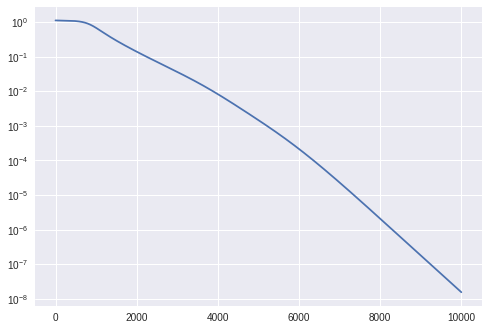

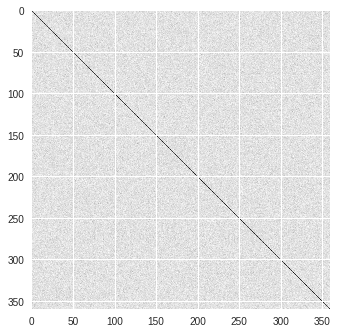

In [202]:
# train
auto_enc_ortho, train_loss_ortho, fishers_ortho, weights_ortho = train_and_get_fishers(data_orth, lin_map_ortho, epochs=10000, init_gain = .05, lr=.1)
plt.semilogy(train_loss_ortho)

#make sure fisher is diagonal
fish = get_orientation_fisher(auto_enc_ortho,lin_map_ortho).detach().cpu().numpy()
plt.figure()
plt.imshow(fish)

Text(0.5, 0, 'Orientation (deg)')

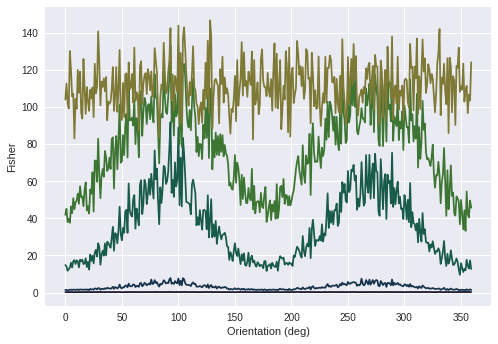

In [205]:
n = 10

epochs = fishers_ortho.shape[1]

colors = sns.color_palette("cubehelix",n)

# which_epochs = range(0,epochs,epochs//n)
which_epochs = [0,600,1200,2000,-1]

for i,e in enumerate(which_epochs):
    plt.plot(smooth(fishers_ortho[e,:],1), c = colors[i])
plt.ylabel("Fisher")
plt.xlabel("Orientation (deg)")

## OKOK the mapping appears not to matter

What about a uniform random distribution?

In [ ]:
lin_map_orth = np.random.random((n_angles,100))-.5

def linear_mapping_orth(orientations_1hot, noise = 0):
    """Inputs: a matrix of shape (N,n_angles)
        Outputs: a matrix of shape (N, output_dim) representing the actual inputs
        noise"""
    
    outputs = np.dot(orientations_1hot, lin_map_orth)
    return  outputs + noise*np.random.randn(*outputs.shape)
data_orth = simulate_data(linear_mapping_orth, prior, N=100000)

# train
auto_enc, train_loss, fishers = train_and_get_fishers(data_orth, lin_map_orth, init_gain=.1, lr = .1,epochs = 5000)
plt.semilogy(train_loss)

#make sure fisher is diagonal
fish = get_orientation_fisher(auto_enc,lin_map_orth).detach().cpu().numpy()
plt.figure()
plt.subplot(121)
plt.imshow(fish)
plt.subplot(122)
plt.plot(np.diag(fish))

In [ ]:
n = 10

epochs = fishers.shape[1]

colors = sns.color_palette("cubehelix",n)

# which_epochs = range(0,epochs,epochs//n)
which_epochs = [0,1500,2500,3500,4999]

for i,e in enumerate(which_epochs):
    plt.plot(smooth(fishers[e,:],1), c = colors[i])
plt.ylabel("Fisher")
plt.xlabel("Orientation (deg)")

## Why is there a maximum at some value? 

## What is the relationship between the prior and the covariance?

In [127]:


data_lin = simulate_data_exact(lambda x:x, prior, N=10000)
cov = np.dot(data_lin.T, data_lin)
cov

9826 10000


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

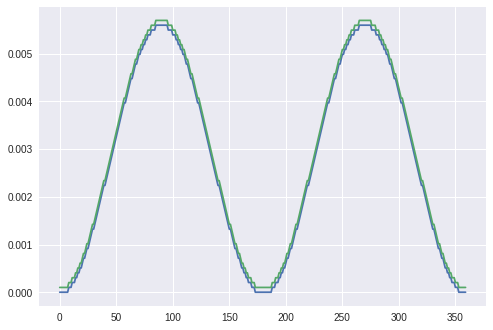

In [128]:
plt.plot(np.mean(data_lin,axis=0), label = "Prior")
plt.plot(np.diag(cov)/np.sum(np.diag(cov))+1e-4)


In [105]:
def exact_1_hot_dist(prior, N, plus_more=False):
    
    """For each element in the prior, we introduce exactly that many examples with that value (rounded)"""
    # make sure prior is normalized
    prior = prior / np.sum(prior)
    n_angles = len(prior)
    
    Ns = np.array((prior * N),dtype=int)
    
    dist = np.zeros((N, len(prior)),dtype=int)
    
    v = 0
    for i, value in enumerate(Ns):
        dist[v:(v+value), i] = 1
        v+=value
        
    print(v,N)
    leftover = N-v
    if plus_more:
        if leftover>1:

            # get orientations
            orientations = np.random.choice(range(n_angles), size=leftover, p=prior)
            # make 1-hot
            orientations = np.eye(n_angles)[orientations]
            dist[v:] = orientations
    else:
        dist= dist[:v]
    return dist

def simulate_data_exact(mapping, prior, N=10000):
    """Each input example has an 'orientation'; it is some mapping of a circular variable binned into e.g. 
        n_angles degrees. 
        
       The orientations are sampled from the prior distribution.
       
       Inputs: mapping: a function that takes an array of orientations (1-hot vectors of size n_angles) 
                           and outputs corresponding examples
               prior: the prior distribution over orientations. shape (n_angles,)
               
       Outputs: examples: shape (N, output_dim)"""
    
    orientations = exact_1_hot_dist(prior, N, plus_more=False)
    
    outputs = mapping(orientations)
    
    return outputs